# %% [markdown]

 # Unified report (01–05): HR segmentation pipeline (OSMI 2016)

 This notebook merges the workflow previously split across:

 - `notebooks/01_data_intake_eda.py`
 - `notebooks/02_cleaning_feature_engineering.py`
 - `notebooks/03_model_comparison.py`
 - `notebooks/04_cluster_interpretation.py`
 - `notebooks/05_predictive_and_actions.py`

 ## How to read this notebook

 **Goal:** produce an HR-usable segmentation described by interpretable workplace levers, then overlay mental-health burden proxies
 for sizing and prioritization (association, not causation).

 **Key design choices (defensible defaults):**
 - **Population restriction:** focus on employees in tech-oriented contexts (HR levers have consistent meaning).
 - **Separation of variables:**
   - *Drivers* define clusters: workplace levers + scored indices/components.
   - *Overlays* are reported after: mental-health status/proxies + demographics/context.
 - **Missingness is not “just missing”:** survey routing creates structural missingness; we treat “not applicable” distinctly.
 - **Representation choices:**
   - One-hot encodes categorical items and scales numeric indices.
   - TruncatedSVD provides a defensible linear geometry.
   - UMAP is treated as a structure-revealing tool (not a proof of cluster validity).
 - **Stability + interpretability checks:** stability across seeds and shallow-tree explainability are used as sanity checks.

 ## Output style (per your request)

 - **DataFrames are displayed** (not written to disk).
 - **Plots are shown inline** (not saved).
 - Markdown is intentionally detailed: it explains why each step exists and how to interpret outputs.

 If you want file outputs to `tmp/notebook_outputs/...`, use the individual notebooks.

In [ ]:
# %%

from __future__ import annotations

import sys
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

sys.path.append(str(Path(__file__).resolve().parents[1]))

from notebooks.lib import (
    load_df_raw,
    build_df_feat,
    feature_sets,
    build_preprocessor,
    to_object_for_cat,
    embed_svd,
    eval_kmeans,
    eval_gmm,
    eval_hdbscan,
    eval_umap_hdbscan,
    stability_ari,
    decision_tree_explainability,
    top_lift_drivers,
    MISSING_TOKEN,
)

sns.set_theme(style="whitegrid")
pd.set_option("display.max_columns", 200)
pd.set_option("display.width", 140)
PALETTE = sns.color_palette()

try:
    from IPython.display import display
except Exception:

    def display(x):  # type: ignore
        print(x)


def show_df(df: pd.DataFrame, title: str | None = None, head: int | None = None):
    if title:
        print(title)
    display(df.head(head) if head is not None else df)


def _clean_str(series: pd.Series) -> pd.Series:
    return series.astype(object).fillna("").astype(str).str.strip()

# %% [markdown]

 ## 1) Data intake + measurement reality (routing, missingness)

 The raw CSV uses full question text as column names. `load_df_raw()`:
 - loads the raw dataset,
 - renames columns to stable short “measure names” via a question→measure map,
 - provides a column mapping table for traceability.

 This is not “cosmetic”: it prevents fragile pipelines and makes every result auditable.

In [ ]:
# %%

df_raw, df_raw_original, col_map = load_df_raw()
show_df(pd.DataFrame([{"df_raw_shape": df_raw.shape, "df_raw_original_shape": df_raw_original.shape}]))
show_df(col_map, "Question → measure map (head)", head=15)

,df_raw_shape,df_raw_original_shape
0,"(1433, 63)","(1433, 63)"


Question → measure map (head)


,idx,question_raw,question_label,measure
0,1,Are you self-employed?,01: Are you self-employed?,self_employed
1,2,How many employees does your company or organi...,02: How many employees does your company or or...,company_size
2,3,Is your employer primarily a tech company/orga...,03: Is your employer primarily a tech company/...,tech_company
3,4,Is your primary role within your company relat...,04: Is your primary role within your company r...,it_worker
4,5,Does your employer provide mental health benef...,05: Does your employer provide mental health b...,benefits
5,6,Do you know the options for mental health care...,06: Do you know the options for mental health ...,benefits_options_known
6,7,Has your employer ever formally discussed ment...,07: Has your employer ever formally discussed ...,formal_discussion
7,8,Does your employer offer resources to learn mo...,08: Does your employer offer resources to lear...,resources_available
8,9,Is your anonymity protected if you choose to t...,09: Is your anonymity protected if you choose ...,anonymity_protected
9,10,If a mental health issue prompted you to reque...,10: If a mental health issue prompted you to r...,leave_ease


# %% [markdown]

 ### 1.1 Missingness overview

 Why this matters:
 - The survey contains skip logic (routing). Many blanks are “not asked”, not “missing at random”.
 - Without explicitly handling routing, clustering can rediscover eligibility patterns rather than HR-lever differences.

 We start with a basic missingness audit: column-wise and row-wise.

In [ ]:
# %%

overview = pd.DataFrame(
    [
        {"metric": "rows", "value": int(df_raw.shape[0])},
        {"metric": "cols", "value": int(df_raw.shape[1])},
        {"metric": "missing_cells", "value": int(df_raw.isna().sum().sum())},
        {"metric": "missing_rate_mean_over_cells", "value": float(df_raw.isna().mean().mean())},
        {"metric": "duplicate_rows", "value": int(df_raw.duplicated().sum())},
    ]
)
show_df(overview, "Raw missingness overview")

Raw missingness overview


,metric,value
0,rows,1433.000000
1,cols,63.000000
2,missing_cells,21960.000000
3,missing_rate_mean_over_cells,0.243246
4,duplicate_rows,0.000000


In [ ]:
# %%

missingness = (
    pd.DataFrame(
        {
            "column": df_raw.columns,
            "dtype": [str(t) for t in df_raw.dtypes],
            "missing_rate": df_raw.isna().mean().values,
            "n_unique_non_missing": [df_raw[c].nunique(dropna=True) for c in df_raw.columns],
        }
    )
    .sort_values("missing_rate", ascending=False)
    .reset_index(drop=True)
)
show_df(missingness.head(25), "Top 25 columns by missing rate")

Top 25 columns by missing rate


,column,dtype,missing_rate,n_unique_non_missing
0,client_reveal_impact,str,0.899512,3
1,productivity_impact_percent,str,0.857641,4
2,it_worker,float64,0.816469,2
3,medical_coverage_mh,float64,0.799721,2
4,reveal_to_clients,str,0.799721,5
5,reveal_to_coworkers,str,0.799721,5
6,coworker_reveal_impact,str,0.799721,4
7,external_resources_known,str,0.799721,3
8,productivity_affected,str,0.799721,4
9,cond_believe_current,str,0.775297,99


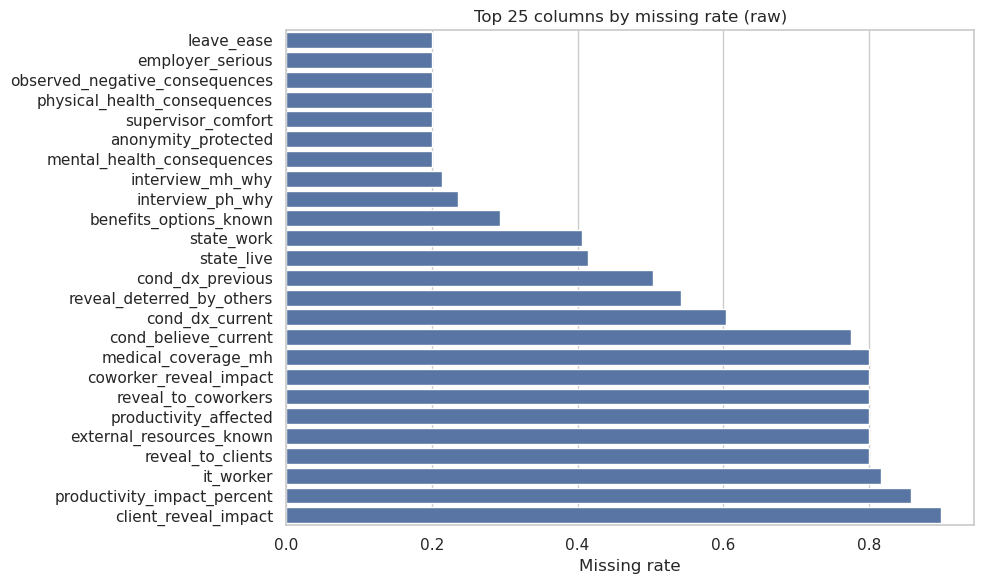

In [ ]:
# %%

fig, ax = plt.subplots(figsize=(10, 6))
top = missingness.head(25).copy().sort_values("missing_rate", ascending=True)
sns.barplot(data=top, x="missing_rate", y="column", color=PALETTE[0], ax=ax)
ax.set_title("Top 25 columns by missing rate (raw)")
ax.set_xlabel("Missing rate")
ax.set_ylabel("")
plt.tight_layout()
plt.show()

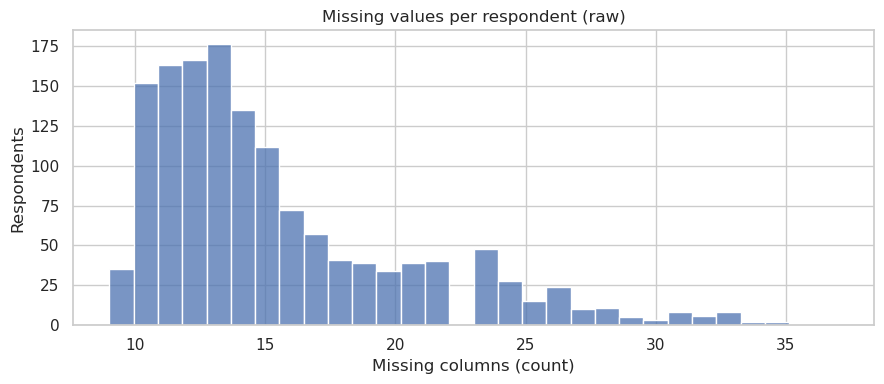

In [ ]:
# %%

fig, ax = plt.subplots(figsize=(9, 4))
row_missing = df_raw.isna().sum(axis=1)
sns.histplot(row_missing, bins=30, color=PALETTE[0], ax=ax)
ax.set_title("Missing values per respondent (raw)")
ax.set_xlabel("Missing columns (count)")
ax.set_ylabel("Respondents")
plt.tight_layout()
plt.show()

# %% [markdown]

 ### 1.1.1 Redundancy among categorical variables (Cramér’s V heatmap)

 A large fraction of HR-lever survey items are categorical (Yes/No/Maybe/Don’t know, buckets, etc.).
 Many of these variables are **redundant** (highly associated), which creates two practical issues:

 1) The one-hot encoded design matrix becomes wide and collinear.
 2) Distance-based clustering in raw one-hot space becomes noisy and can overweight correlated blocks.

 This is one of the motivations for the **TruncatedSVD step** later: it compresses correlated one-hot structure into a smaller number
 of continuous components.

 We visualize redundancy using **Cramér’s V** (an association measure for categorical variables):
 - 0 ≈ no association,
 - 1 ≈ strong association.

 Note: this is computed on a selected set of “core” categorical workplace/context variables (not every high-cardinality text field).

Cramér’s V association matrix (selected categorical variables)


,company_size,remote_work,benefits,benefits_options_known,formal_discussion,resources_available,anonymity_protected,leave_ease,employer_serious,mental_health_consequences,physical_health_consequences,coworker_comfort,supervisor_comfort,observed_negative_consequences,career_harm,team_views_negative,tech_company,it_worker
company_size,1.000000,0.206371,0.527204,0.456981,0.590875,0.617256,0.594468,0.413310,0.582981,0.581277,0.576874,0.581336,0.578862,0.705985,0.000000,0.079031,0.739965,0.272437
remote_work,0.206371,1.000000,0.207853,0.129151,0.202598,0.203917,0.196870,0.213771,0.215916,0.212102,0.196209,0.217498,0.220437,0.197208,0.063939,0.033964,0.230067,0.165216
benefits,0.527204,0.207853,1.000000,0.583586,0.589708,0.641271,0.613400,0.502166,0.581409,0.581148,0.578056,0.583646,0.581713,0.707963,0.063702,0.077043,0.706118,0.163571
benefits_options_known,0.456981,0.129151,0.583586,1.000000,0.457984,0.481310,0.473390,0.451976,0.453950,0.451522,0.449405,0.455321,0.454474,0.548328,0.074502,0.073794,0.548414,0.141708
formal_discussion,0.590875,0.202598,0.589708,0.457984,1.000000,0.654832,0.598738,0.589021,0.606773,0.586761,0.578533,0.587896,0.591673,0.706461,0.053901,0.089174,0.710446,0.182657
resources_available,0.617256,0.203917,0.641271,0.481310,0.654832,1.000000,0.611698,0.583928,0.590534,0.580797,0.579092,0.580788,0.586553,0.709195,0.052757,0.071125,0.715606,0.197968
anonymity_protected,0.594468,0.196870,0.613400,0.473390,0.598738,0.611698,1.000000,0.593876,0.595848,0.594747,0.581430,0.587966,0.597316,0.707837,0.089397,0.124677,0.706671,0.169760
leave_ease,0.413310,0.213771,0.502166,0.451976,0.589021,0.583928,0.593876,1.000000,0.640305,0.671494,0.609834,0.611473,0.635518,0.714547,0.159086,0.184068,0.711721,0.192828
employer_serious,0.582981,0.215916,0.581409,0.453950,0.606773,0.590534,0.595848,0.640305,1.000000,0.651482,0.596542,0.602770,0.629295,0.722791,0.153846,0.166949,0.707256,0.166228
mental_health_consequences,0.581277,0.212102,0.581148,0.451522,0.586761,0.580797,0.594747,0.671494,0.651482,1.000000,0.662061,0.635135,0.672965,0.726219,0.267779,0.289355,0.709460,0.185566


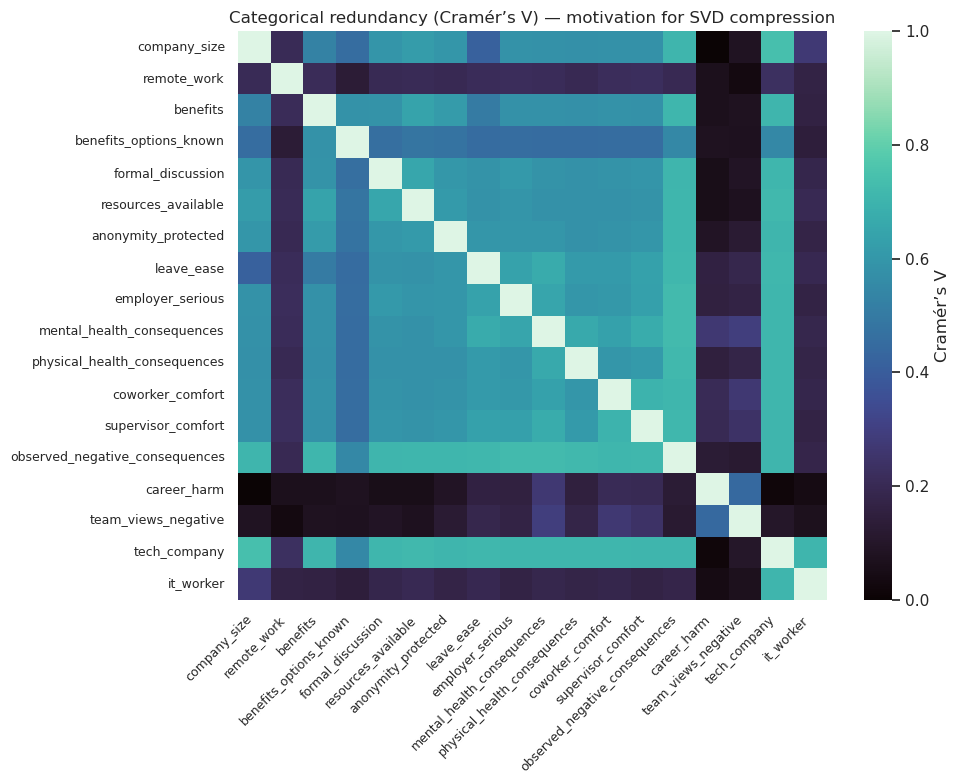

In [ ]:
# %%

try:
    from scipy.stats import chi2_contingency

    def cramers_v(a: pd.Series, b: pd.Series) -> float:
        x = _clean_str(a).replace("", "__MISSING__")
        y = _clean_str(b).replace("", "__MISSING__")
        tab = pd.crosstab(x, y)
        if tab.shape[0] <= 1 or tab.shape[1] <= 1:
            return float("nan")
        chi2 = chi2_contingency(tab.values, correction=False)[0]
        n = tab.values.sum()
        if n <= 0:
            return float("nan")
        r, k = tab.shape
        phi2 = max(0.0, chi2 / n)
        # Bias correction (Bergsma & Wicher) to reduce inflation in small tables.
        phi2corr = max(0.0, phi2 - ((k - 1) * (r - 1)) / max(n - 1, 1))
        rcorr = r - ((r - 1) ** 2) / max(n - 1, 1)
        kcorr = k - ((k - 1) ** 2) / max(n - 1, 1)
        denom = max(min(kcorr - 1, rcorr - 1), 1e-12)
        return float(np.sqrt(phi2corr / denom))


    candidate_cats = [
        "company_size",
        "remote_work",
        "benefits",
        "benefits_options_known",
        "formal_discussion",
        "resources_available",
        "anonymity_protected",
        "leave_ease",
        "employer_serious",
        "mental_health_consequences",
        "physical_health_consequences",
        "coworker_comfort",
        "supervisor_comfort",
        "observed_negative_consequences",
        "career_harm",
        "team_views_negative",
        "tech_company",
        "it_worker",
    ]
    cat_cols = [c for c in candidate_cats if c in df_raw.columns]
    # Keep only columns with manageable cardinality (avoid giant sparse crosstabs).
    cat_cols = [c for c in cat_cols if df_raw[c].nunique(dropna=True) <= 15]

    V = pd.DataFrame(index=cat_cols, columns=cat_cols, dtype=float)
    for i, ci in enumerate(cat_cols):
        for j, cj in enumerate(cat_cols):
            if j < i:
                V.loc[ci, cj] = V.loc[cj, ci]
                continue
            V.loc[ci, cj] = 1.0 if ci == cj else cramers_v(df_raw[ci], df_raw[cj])

    show_df(V, "Cramér’s V association matrix (selected categorical variables)")

    fig, ax = plt.subplots(figsize=(10, 8))
    sns.heatmap(V, vmin=0, vmax=1, cmap="mako", ax=ax, cbar_kws={"label": "Cramér’s V"})
    ax.set_title("Categorical redundancy (Cramér’s V) — motivation for SVD compression")
    ax.tick_params(axis="x", rotation=45, labelsize=9)
    ax.tick_params(axis="y", labelsize=9)
    for lbl in ax.get_xticklabels():
        lbl.set_horizontalalignment("right")
    plt.tight_layout()
    plt.show()
except Exception as e:
    print("Cramér’s V heatmap skipped (scipy not available or computation failed):", repr(e))

# %% [markdown]

 ### 1.2 Routing gates and why we restrict the population

 The HR deliverable is an intervention plan for organizations. Many employer-policy items are not comparable for self-employed respondents,
 so the main HR segmentation is restricted to employees.

 In addition, we focus on tech-oriented contexts (as encoded in the survey) to reduce heterogeneity that would dilute actionability.

In [ ]:
# %%

counts = {}
if "self_employed" in df_raw.columns:
    counts["n_total"] = int(len(df_raw))
    counts["n_employees"] = int((df_raw["self_employed"] == 0).sum())
    counts["n_self_employed"] = int((df_raw["self_employed"] == 1).sum())
show_df(pd.DataFrame([counts]), "Routing: self-employed split")

Routing: self-employed split


,n_total,n_employees,n_self_employed
0,1433,1146,287


# %% [markdown]

 ### 1.3 Raw burden proxy context (base rates)

 Burden proxies (outcomes) are **not used to define clusters**. They are overlaid later.
 Showing their raw distributions early prevents “surprise” when base rates differ after filtering.

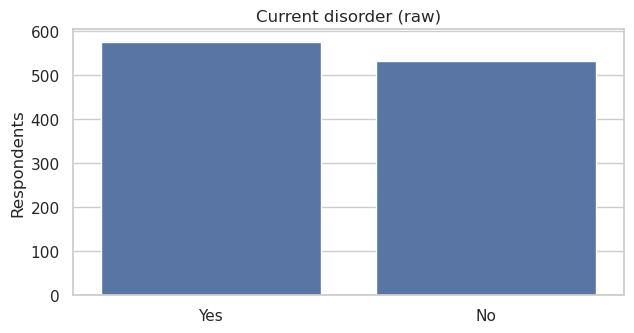

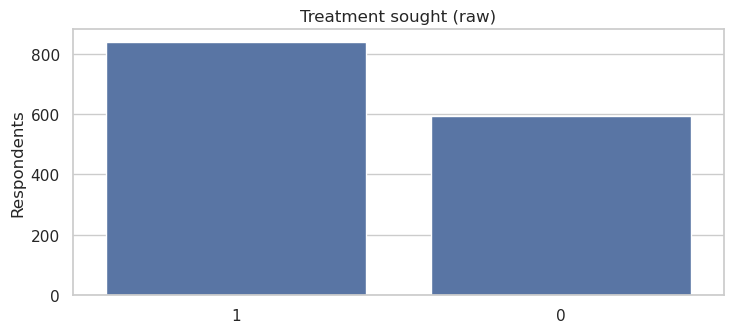

In [ ]:
# %%

if "current_disorder" in df_raw.columns:
    s = _clean_str(df_raw["current_disorder"]).replace("", "__MISSING__")
    fig, ax = plt.subplots(figsize=(6.5, 3.5))
    sns.countplot(x=s, order=[o for o in ["Yes", "No", "__MISSING__"] if o in s.unique()], color=PALETTE[0], ax=ax)
    ax.set_title("Current disorder (raw)")
    ax.set_xlabel("")
    ax.set_ylabel("Respondents")
    plt.tight_layout()
    plt.show()

if "treatment_sought" in df_raw.columns:
    s = _clean_str(df_raw["treatment_sought"]).replace("", "__MISSING__")
    fig, ax = plt.subplots(figsize=(7.5, 3.5))
    order = [o for o in ["Yes", "No", "1", "0", "__MISSING__"] if o in s.unique()]
    sns.countplot(x=s, order=order, color=PALETTE[0], ax=ax)
    ax.set_title("Treatment sought (raw)")
    ax.set_xlabel("")
    ax.set_ylabel("Respondents")
    plt.tight_layout()
    plt.show()

# %% [markdown]

 ### 1.4 Basic EDA (age outliers, top gender strings, top roles)

 These are not “model features” yet; they are reality checks:
 - Age can contain outliers or implausible values in surveys; later we keep only a plausible range.
 - Gender and role fields are high-cardinality / messy text. For modeling we use cleaned `gender_norm` and role indicators, but raw counts
   help justify those transformations.

Age summary (raw, highlights outliers)


,min,p01,median,p99,max,n_lt_16,n_gt_80
0,3.0,21.0,33.0,58.68,323.0,2,2


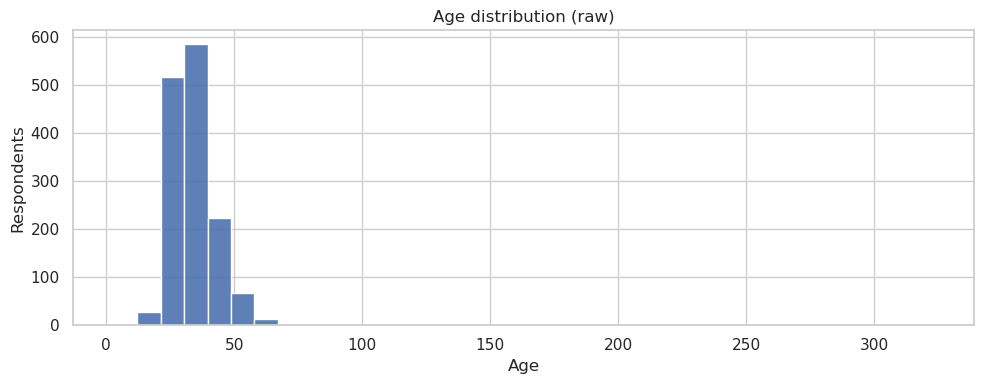

In [ ]:
# %%

if "age" in df_raw.columns:
    age = pd.to_numeric(df_raw["age"], errors="coerce")
    show_df(
        pd.DataFrame(
            [
                {
                    "min": float(age.min()),
                    "p01": float(age.quantile(0.01)),
                    "median": float(age.quantile(0.50)),
                    "p99": float(age.quantile(0.99)),
                    "max": float(age.max()),
                    "n_lt_16": int((age < 16).sum()),
                    "n_gt_80": int((age > 80).sum()),
                }
            ]
        ),
        "Age summary (raw, highlights outliers)",
    )

    fig, ax = plt.subplots(figsize=(10, 4))
    sns.histplot(age.dropna(), bins=35, color=PALETTE[0], alpha=0.9, ax=ax)
    ax.set_title("Age distribution (raw)")
    ax.set_xlabel("Age")
    ax.set_ylabel("Respondents")
    plt.tight_layout()
    plt.show()

In [ ]:
# %%

if "gender" in df_raw.columns:
    gender_counts = _clean_str(df_raw["gender"]).replace("", "__MISSING__").value_counts().head(25).rename_axis("gender_raw").reset_index(name="n")
    show_df(gender_counts, "Top 25 raw gender strings (high-cardinality field)")

Top 25 raw gender strings (high-cardinality field)


,gender_raw,n
0,Male,621
1,male,251
2,Female,163
3,female,98
4,M,86
5,m,79
6,F,38
7,f,23
8,non-binary,4
9,woman,4


In [ ]:
# %%

if "work_position" in df_raw.columns:
    pos_counts = _clean_str(df_raw["work_position"]).replace("", "__MISSING__").value_counts().head(25).rename_axis("work_position_raw").reset_index(name="n")
    show_df(pos_counts, "Top 25 raw work_position strings (multi-select text)")

Top 25 raw work_position strings (multi-select text)


,work_position_raw,n
0,Back-end Developer,263
1,Front-end Developer,125
2,Other,112
3,Supervisor/Team Lead,68
4,Back-end Developer|Front-end Developer,61
5,DevOps/SysAdmin,54
6,One-person shop,50
7,Executive Leadership,46
8,Front-end Developer|Back-end Developer,40
9,Support,34


# %% [markdown]

 ## 2) Cleaning + feature engineering (HR levers + interpretable scores)

 `build_df_feat()` constructs the modeling dataset. It is the “ground truth” transformation for later notebooks.

 What it does (high-level):
 - filters to employees in tech-oriented contexts,
 - performs routing-aware missingness handling for selected blocks (`__not_applicable__`),
 - creates interpretable scored items and indices:
   - `sc_support__*`, `idx_support`
   - `sc_safety__*`, `idx_safety`
 - adds response-quality diagnostics:
   - `qc_unknown_count` (how often respondents answer “I don’t know” on workplace items),
   - `qc_missing_count` (how many workplace items are missing).

 Why both indices and item-level scores exist:
 - indices are interpretable and stable, good for HR dashboards,
 - item-level scores preserve information and support lift/driver interpretation.

In [ ]:
# %%

df_feat = build_df_feat()
show_df(pd.DataFrame([{"df_feat_shape": df_feat.shape}]), "Modeling dataset shape")
sets = feature_sets(df_feat)
show_df(pd.DataFrame([{"feature_set": k, "n_cols": len(v)} for k, v in sets.items()]).sort_values("n_cols", ascending=False), "Feature sets (column counts)")

Modeling dataset shape


,df_feat_shape
0,"(1131, 149)"


Feature sets (column counts)


,feature_set,n_cols
2,workplace_plus_roles,27
5,scored_items,17
3,workplace_plus_role_summaries,17
6,scored_items_no_gap,16
0,workplace_no_roles,15
1,workplace_no_roles_no_gap,14
4,indices_only,4


# %% [markdown]

 ### 2.1 Population flow: raw → employees → tech-oriented → final df_feat

 This documents the preprocessing funnel and makes it explicit that “the model sees a subset”.

In [ ]:
# %%

employees_n = int((df_raw["self_employed"] == 0).sum()) if "self_employed" in df_raw.columns else int(len(df_raw))
non_tech_removed = int(employees_n - len(df_feat))
show_df(
    pd.DataFrame(
        [
            {"stage": "raw_total", "n": int(len(df_raw))},
            {"stage": "employees_only", "n": employees_n},
            {"stage": "removed (non-tech-oriented / routing constraints)", "n": non_tech_removed},
            {"stage": "final_df_feat", "n": int(len(df_feat))},
        ]
    ),
    "Population flow counts",
)

Population flow counts


,stage,n
0,raw_total,1433
1,employees_only,1146
2,removed (non-tech-oriented / routing constraints),15
3,final_df_feat,1131


# %% [markdown]

 ### 2.2 Index distributions (compact, interpretable axes)

 These distributions show:
 - whether indices have usable variation (not all 0/1),
 - whether values are concentrated (which can limit discriminative power),
 - and whether extreme missingness exists (coverage).

In [ ]:
# %%

idx_cols = [c for c in ["idx_support", "idx_safety", "idx_support_n", "idx_safety_n"] if c in df_feat.columns]
show_df(df_feat[idx_cols].describe().T, "Index summaries")

Index summaries


,count,mean,std,min,25%,50%,75%,max
idx_support,1128.0,0.462154,0.312619,0.0,0.1875,0.45,0.7,1.0
idx_safety,1131.0,0.486472,0.287964,0.0,0.3000,0.50,0.7,1.0
idx_support_n,1131.0,4.638373,1.428253,0.0,4.0000,5.00,6.0,7.0
idx_safety_n,1131.0,5.000000,0.000000,5.0,5.0000,5.00,5.0,5.0


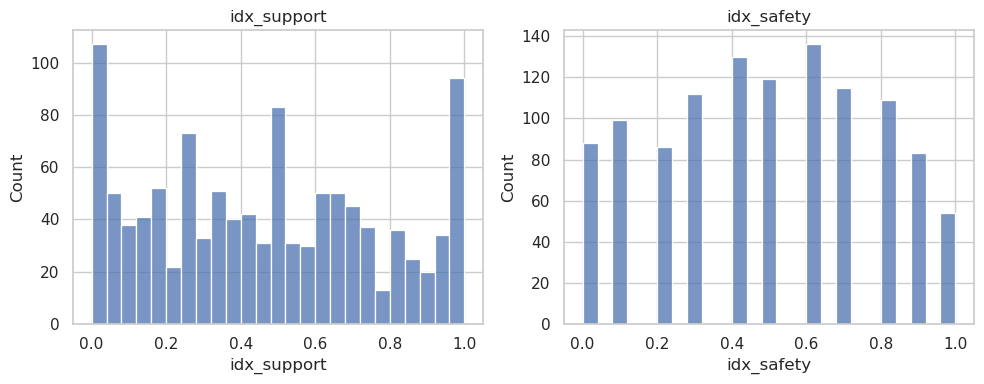

In [ ]:
# %%

fig, axes = plt.subplots(1, 2, figsize=(10, 4))
sns.histplot(df_feat["idx_support"].dropna(), bins=25, ax=axes[0], color=PALETTE[0])
axes[0].set_title("idx_support")
sns.histplot(df_feat["idx_safety"].dropna(), bins=25, ax=axes[1], color=PALETTE[0])
axes[1].set_title("idx_safety")
plt.tight_layout()
plt.show()

# %% [markdown]

 ### 2.2.1 The “benefits visibility gap” KPI

 The engineered KPI `gap__benefits_yes_but_not_yes_options` is a dominant binary axis in many survey analyses:

 - it captures a concrete HR-lever problem: “benefits exist” but “options are not discoverable/known”,
 - it often separates “well-supported” vs “confused/unaware” subpopulations.

 We show its distribution early because it can dominate clustering if included naïvely.

Gap KPI distribution (counts)


,n
gap__benefits_yes_but_not_yes_options,
0,879
1,252


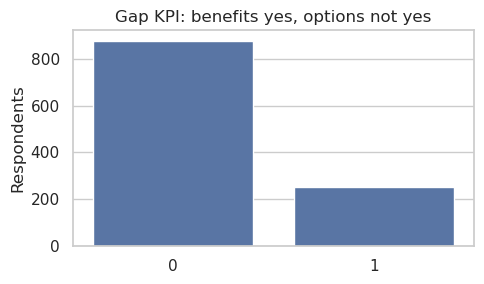

In [ ]:
# %%

gap = "gap__benefits_yes_but_not_yes_options"
if gap in df_feat.columns:
    show_df(df_feat[gap].value_counts(dropna=False).rename_axis(gap).to_frame("n"), "Gap KPI distribution (counts)")
    fig, ax = plt.subplots(figsize=(5, 3))
    sns.countplot(x=gap, data=df_feat, color=PALETTE[0], ax=ax)
    ax.set_title("Gap KPI: benefits yes, options not yes")
    ax.set_xlabel("")
    ax.set_ylabel("Respondents")
    plt.tight_layout()
    plt.show()

# %% [markdown]

 ### 2.2.2 Correlation among engineered numeric features (Spearman)

 We use Spearman correlation because several engineered variables are:
 - ordinal / bounded (0–1 scores),
 - counts with skew,
 - and monotonic relationships are more plausible than linear ones.

 This plot is a *diagnostic*:
 - strong correlations indicate redundancy (useful for interpretation, may affect coefficients),
 - it also checks that “QC” variables are not perfectly entangled with indices.

Engineered numeric Spearman correlation


,idx_support,idx_safety,qc_unknown_count,qc_missing_count,role__count,role__multi_role,age_clean,cond__any_reported,gap__benefits_yes_but_not_yes_options
idx_support,1.000000,0.420388,-0.226233,0.014154,-0.004523,-0.007113,0.100741,-0.016196,0.194538
idx_safety,0.420388,1.000000,-0.108742,0.073285,0.057417,0.053043,-0.018318,-0.102413,-0.015261
qc_unknown_count,-0.226233,-0.108742,1.000000,0.055058,-0.017895,-0.002460,-0.027633,-0.090906,0.043856
qc_missing_count,0.014154,0.073285,0.055058,1.000000,0.033172,0.038357,-0.010697,-0.077460,-0.039103
role__count,-0.004523,0.057417,-0.017895,0.033172,1.000000,0.962606,-0.019592,0.028377,-0.042951
role__multi_role,-0.007113,0.053043,-0.002460,0.038357,0.962606,1.000000,-0.024284,0.041973,-0.055929
age_clean,0.100741,-0.018318,-0.027633,-0.010697,-0.019592,-0.024284,1.000000,0.021228,0.117337
cond__any_reported,-0.016196,-0.102413,-0.090906,-0.077460,0.028377,0.041973,0.021228,1.000000,-0.018029
gap__benefits_yes_but_not_yes_options,0.194538,-0.015261,0.043856,-0.039103,-0.042951,-0.055929,0.117337,-0.018029,1.000000


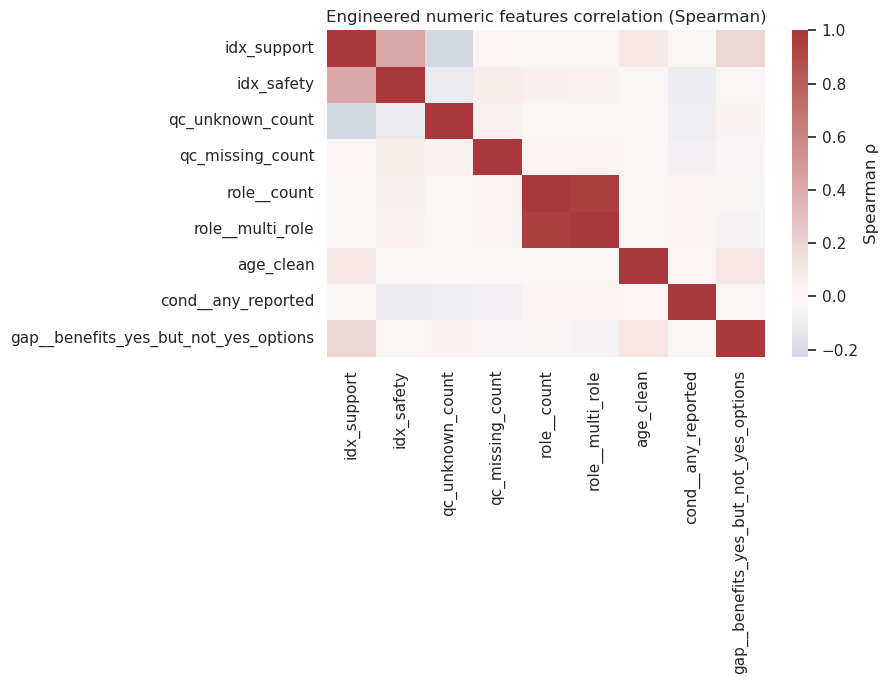

In [ ]:
# %%

num_cols = [
    "idx_support",
    "idx_safety",
    "qc_unknown_count",
    "qc_missing_count",
    "role__count",
    "role__multi_role",
    "age_clean",
    "cond__any_reported",
    gap,
]
num_cols = [c for c in num_cols if c in df_feat.columns]
if num_cols:
    corr = df_feat[num_cols].corr(method="spearman")
    show_df(corr, "Engineered numeric Spearman correlation")
    fig, ax = plt.subplots(figsize=(9, 7))
    sns.heatmap(corr, cmap="vlag", center=0, ax=ax, cbar_kws={"label": "Spearman ρ"})
    ax.set_title("Engineered numeric features correlation (Spearman)")
    plt.tight_layout()
    plt.show()

# %% [markdown]

 ### 2.3 Outcome base rates: original vs filtered

 Filtering changes population composition. Any “predictive performance” has to be interpreted relative to these base rates.
 We also track “not applicable” coverage for interference outcomes.

In [ ]:
# %%

def _summarize_binary(series: pd.Series, positive_values: set[str], not_applicable_value: str | None = None):
    s = _clean_str(series)
    missing = s.eq("")
    not_applicable = s.eq(not_applicable_value) if not_applicable_value is not None else pd.Series(False, index=s.index)
    applicable = ~missing & ~not_applicable
    pos = s.isin(list(positive_values)) & applicable
    n_total = int(len(s))
    n_applicable = int(applicable.sum())
    return {
        "n_total": n_total,
        "n_applicable": n_applicable,
        "n_positive": int(pos.sum()),
        "positive_rate_applicable": float(pos.sum() / n_applicable) if n_applicable > 0 else float("nan"),
        "missing_rate": float(missing.mean()),
        "not_applicable_rate": float(not_applicable.mean()),
    }


outcome_defs = [
    {"outcome": "current_disorder_yes", "col": "current_disorder", "pos": {"Yes"}, "na": None},
    {"outcome": "treatment_yes", "col": "treatment_sought", "pos": {"Yes", "1", "1.0"}, "na": None},
    {"outcome": "work_interference_untreated_often", "col": "work_interference_untreated", "pos": {"Often"}, "na": "Not applicable to me"},
]

rows = []
for dset_name, frame in [("original", df_raw), ("filtered_df_feat", df_feat)]:
    for od in outcome_defs:
        if od["col"] not in frame.columns:
            continue
        rows.append({"dataset": dset_name, "outcome": od["outcome"], **_summarize_binary(frame[od["col"]], od["pos"], od["na"])})

mh_rates = pd.DataFrame(rows).sort_values(["outcome", "dataset"]).reset_index(drop=True)
show_df(mh_rates, "Outcome base rates and coverage")

Outcome base rates and coverage


,dataset,outcome,n_total,n_applicable,n_positive,positive_rate_applicable,missing_rate,not_applicable_rate
0,filtered_df_feat,current_disorder_yes,1131,1131,445,0.393457,0.0,0.000000
1,original,current_disorder_yes,1433,1433,575,0.401256,0.0,0.000000
2,filtered_df_feat,treatment_yes,1131,1131,649,0.573828,0.0,0.000000
3,original,treatment_yes,1433,1433,839,0.585485,0.0,0.000000
4,filtered_df_feat,work_interference_untreated_often,1131,753,415,0.551129,0.0,0.334218
5,original,work_interference_untreated_often,1433,965,538,0.557513,0.0,0.326588


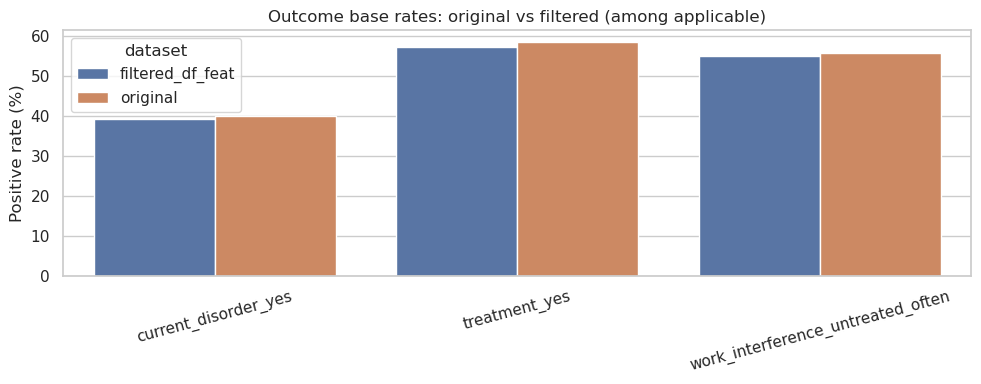

In [ ]:
# %%

fig, ax = plt.subplots(figsize=(10, 4))
plot_df = mh_rates.copy()
plot_df = plot_df[plot_df.groupby("outcome")["n_applicable"].transform("min") > 0].copy()
plot_df["positive_rate_pct_applicable"] = plot_df["positive_rate_applicable"] * 100.0
sns.barplot(data=plot_df, x="outcome", y="positive_rate_pct_applicable", hue="dataset", ax=ax)
ax.set_title("Outcome base rates: original vs filtered (among applicable)")
ax.set_xlabel("")
ax.set_ylabel("Positive rate (%)")
ax.tick_params(axis="x", rotation=15)
plt.tight_layout()
plt.show()

# %% [markdown]

 ## 3) Model comparison (KMeans/GMM/HDBSCAN, SVD space vs UMAP space)

 We compare:
 - **KMeans/GMM** as baseline convex clusterers in SVD space,
 - **HDBSCAN** in SVD space (density-based on linear geometry),
 - **UMAP + HDBSCAN** as exploratory (nonlinear embedding + density clustering).

 We do not “optimize silhouette” as the objective. For HR segmentation, we want:
 - stable clusters,
 - interpretable levers,
 - and segment sizes usable for interventions.

 ### Metrics (what to trust, what not to overread)

 - **Silhouette** can be low even for meaningful segments when clusters overlap (common in survey data). Treat as a diagnostic, not a goal.
 - **Inertia** always decreases with k; use it only as an elbow heuristic.
 - **GMM BIC/AIC** are likelihood criteria under Gaussian assumptions; for one-hot survey data, treat as heuristics.
 - **HDBSCAN noise fraction** matters operationally: too much noise means many respondents are not assigned to a segment.
 - **Decision-tree explainability (macro-F1)** is a sanity check: can we describe clusters with simple rules on interpretable levers?

In [ ]:
# %%

compare_sets = {
    "workplace_no_roles": sets["workplace_no_roles"],
    "workplace_no_roles_no_gap": sets["workplace_no_roles_no_gap"],
    "scored_items_no_gap": sets["scored_items_no_gap"],
}
k_range = [2, 3, 4, 5, 6, 7, 8]
explain_X = df_feat[sets["scored_items_no_gap"]].copy()

In [ ]:
# %%

rows = []
for set_name, cols in compare_sets.items():
    X = to_object_for_cat(df_feat[cols].copy())
    pre = build_preprocessor(X, min_frequency=10)
    Xt = pre.fit_transform(X)
    _, Z = embed_svd(Xt, n_components=15)

    for k in k_range:
        km = eval_kmeans(Z, k)
        rows.append(
            {
                "feature_set": set_name,
                "model": "kmeans",
                "k": int(k),
                "silhouette_svd": km["silhouette"],
                "inertia": km["inertia"],
                "bic": np.nan,
                "aic": np.nan,
            }
        )

    for cov in ["diag"]:
        for k in k_range:
            gg = eval_gmm(Z, k, covariance_type=cov)
            rows.append(
                {
                    "feature_set": set_name,
                    "model": f"gmm_{cov}",
                    "k": int(k),
                    "silhouette_svd": gg["silhouette"],
                    "inertia": np.nan,
                    "bic": gg["bic"],
                    "aic": gg["aic"],
                }
            )

baseline = pd.DataFrame(rows)
show_df(baseline.head(30), "Baseline (KMeans + GMM) metrics (head)")

Baseline (KMeans + GMM) metrics (head)


,feature_set,model,k,silhouette_svd,inertia,bic,aic
0,workplace_no_roles,kmeans,2,0.208000,6534.764691,NaN,NaN
1,workplace_no_roles,kmeans,3,0.163442,5719.134764,NaN,NaN
2,workplace_no_roles,kmeans,4,0.143910,5295.976034,NaN,NaN
3,workplace_no_roles,kmeans,5,0.136131,5019.150345,NaN,NaN
4,workplace_no_roles,kmeans,6,0.125955,4821.780762,NaN,NaN
5,workplace_no_roles,kmeans,7,0.122402,4627.894612,NaN,NaN
6,workplace_no_roles,kmeans,8,0.120874,4465.660319,NaN,NaN
7,workplace_no_roles,gmm_diag,2,0.095519,NaN,31307.636485,31000.754179
8,workplace_no_roles,gmm_diag,3,0.163455,NaN,30526.194567,30063.355680
9,workplace_no_roles,gmm_diag,4,0.135354,NaN,29875.782715,29256.987245


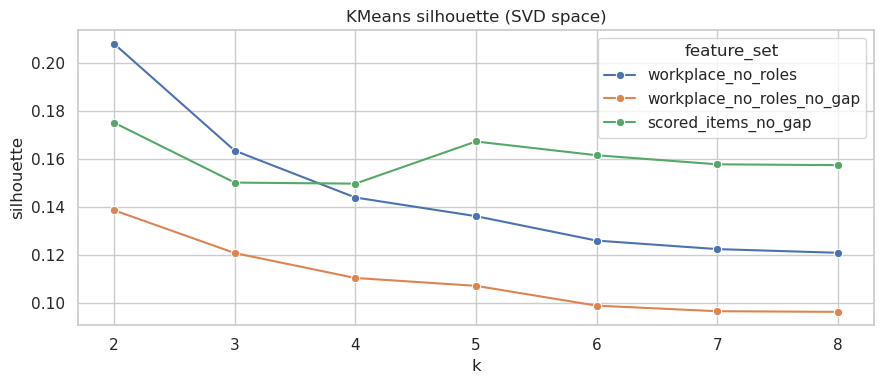

In [ ]:
# %%

fig, ax = plt.subplots(figsize=(9, 4))
tmp = baseline[baseline["model"].eq("kmeans")].copy()
sns.lineplot(data=tmp, x="k", y="silhouette_svd", hue="feature_set", marker="o", ax=ax)
ax.set_title("KMeans silhouette (SVD space)")
ax.set_xlabel("k")
ax.set_ylabel("silhouette")
plt.tight_layout()
plt.show()

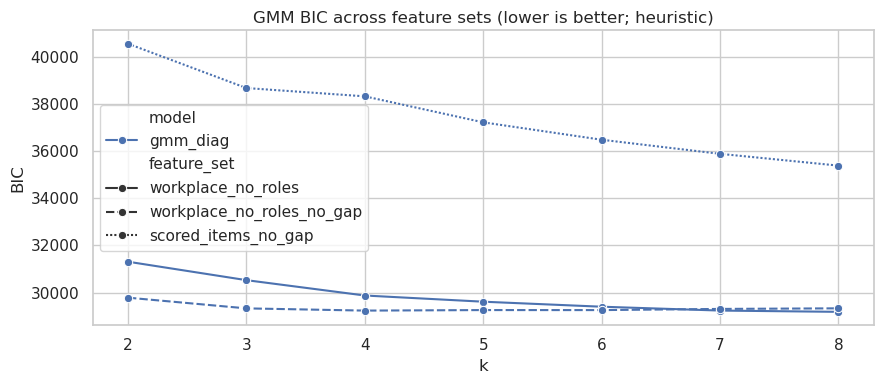

In [ ]:
# %%

fig, ax = plt.subplots(figsize=(9, 4))
tmp = baseline[baseline["model"].str.startswith("gmm_")].copy()
sns.lineplot(data=tmp, x="k", y="bic", hue="model", style="feature_set", marker="o", ax=ax)
ax.set_title("GMM BIC across feature sets (lower is better; heuristic)")
ax.set_xlabel("k")
ax.set_ylabel("BIC")
plt.tight_layout()
plt.show()

In [ ]:
# %%

rows = []
for set_name, cols in compare_sets.items():
    X = to_object_for_cat(df_feat[cols].copy())
    pre = build_preprocessor(X, min_frequency=10)
    Xt = pre.fit_transform(X)
    _, Z = embed_svd(Xt, n_components=15)
    for metric in ["euclidean", "manhattan"]:
        for min_cluster_size in [25, 50]:
            res = eval_hdbscan(Z, min_cluster_size=min_cluster_size, min_samples=None, metric=metric)
            exp = decision_tree_explainability(explain_X, res["labels"], max_depth=3, n_splits=5, seed=0)
            rows.append({"feature_set": set_name, "metric": metric, "min_cluster_size": int(min_cluster_size), **res, **exp})

hdb_svd = pd.DataFrame(rows).sort_values(["relative_validity", "silhouette_inliers"], ascending=[False, False])
show_df(hdb_svd.head(20), "HDBSCAN on SVD space (top configs)")

HDBSCAN on SVD space (top configs)


,feature_set,metric,min_cluster_size,labels,n_clusters,noise_frac,silhouette_inliers,relative_validity,tree_macro_f1,tree_n
10,scored_items_no_gap,manhattan,25,"[2, -1, 1, -1, -1, 2, -1, -1, -1, -1, 2, -1, -...",4,0.671972,0.241681,0.056876,0.989365,371
0,workplace_no_roles,euclidean,25,"[0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, ...",2,0.022989,0.207432,0.011714,1.000000,1105
8,scored_items_no_gap,euclidean,25,"[1, 1, 1, -1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,...",2,0.072502,0.273004,0.004870,1.000000,1049
1,workplace_no_roles,euclidean,50,"[1, 1, 1, 1, -1, 1, 1, 1, -1, 1, -1, 1, 1, 1, ...",2,0.183024,0.194026,0.000579,1.000000,924
4,workplace_no_roles_no_gap,euclidean,25,"[0, -1, 0, -1, -1, -1, -1, -1, -1, -1, 1, -1, ...",2,0.786914,0.326953,0.000107,0.971830,241
2,workplace_no_roles,manhattan,25,"[0, -1, 0, -1, -1, -1, -1, -1, -1, -1, -1, -1,...",2,0.859416,0.414917,0.000038,0.864293,159
6,workplace_no_roles_no_gap,manhattan,25,"[1, -1, 1, -1, -1, -1, -1, -1, -1, -1, -1, -1,...",2,0.839080,0.364620,0.000032,0.943345,182
3,workplace_no_roles,manhattan,50,"[-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -...",0,1.000000,NaN,0.000000,NaN,0
5,workplace_no_roles_no_gap,euclidean,50,"[-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -...",0,1.000000,NaN,0.000000,NaN,0
7,workplace_no_roles_no_gap,manhattan,50,"[-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -...",0,1.000000,NaN,0.000000,NaN,0


In [ ]:
# %%

rows = []
for set_name, cols in compare_sets.items():
    X = to_object_for_cat(df_feat[cols].copy())
    pre = build_preprocessor(X, min_frequency=10)
    Xt = pre.fit_transform(X)
    _, Z = embed_svd(Xt, n_components=15)

    configs = [
        {"n_neighbors": 10, "min_dist": 0.1, "min_cluster_size": 50},
        {"n_neighbors": 30, "min_dist": 0.1, "min_cluster_size": 50},
        {"n_neighbors": 10, "min_dist": 0.0, "min_cluster_size": 50},
        {"n_neighbors": 10, "min_dist": 0.1, "min_cluster_size": 25},
    ]
    for cfg in configs:
        res = eval_umap_hdbscan(Z, umap_dim=5, n_neighbors=cfg["n_neighbors"], min_dist=cfg["min_dist"], min_cluster_size=cfg["min_cluster_size"], min_samples=None, seed=0)
        exp = decision_tree_explainability(explain_X, res["labels"], max_depth=3, n_splits=5, seed=0)
        labels_seeds = [
            eval_umap_hdbscan(Z, umap_dim=5, n_neighbors=cfg["n_neighbors"], min_dist=cfg["min_dist"], min_cluster_size=cfg["min_cluster_size"], min_samples=None, seed=s)["labels"]
            for s in [0, 1, 2]
        ]
        rows.append({**cfg, "feature_set": set_name, **{k: res[k] for k in ["n_clusters", "noise_frac", "relative_validity", "silhouette_umap_inliers", "silhouette_svd_inliers"]}, "stability_ari_seeds_0_1_2": stability_ari(labels_seeds), **exp})

umap_hdb = pd.DataFrame(rows).sort_values(["tree_macro_f1", "relative_validity", "silhouette_umap_inliers"], ascending=[False, False, False])
show_df(umap_hdb.head(20), "UMAP + HDBSCAN configs (top)")

/home/gustas/software/miniconda3/envs/mental/lib/python3.11/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/home/gustas/software/miniconda3/envs/mental/lib/python3.11/site-packages/numba/np/ufunc/parallel.py:373: NumbaWarning: The TBB threading layer requires TBB version 2021 update 6 or later i.e., TBB_INTERFACE_VERSION >= 12060. Found TBB_INTERFACE_VERSION = 12050. The TBB threading layer is disabled.
  warnings.warn(problem)
/home/gustas/software/miniconda3/envs/mental/lib/python3.11/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/home/gustas/software/miniconda3/envs/mental/lib/python3.11/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/home/gustas/software/miniconda3/envs/mental/lib/python3.11/site-packages/u

UMAP + HDBSCAN configs (top)


,n_neighbors,min_dist,min_cluster_size,feature_set,n_clusters,noise_frac,relative_validity,silhouette_umap_inliers,silhouette_svd_inliers,stability_ari_seeds_0_1_2,tree_macro_f1,tree_n
1,30,0.1,50,workplace_no_roles,2,0.000000,0.931985,0.890183,0.208000,1.000000,1.000000,1131
3,10,0.1,25,workplace_no_roles,2,0.000000,0.927505,0.867076,0.208000,1.000000,1.000000,1131
0,10,0.1,50,workplace_no_roles,2,0.000000,0.914228,0.867076,0.208000,1.000000,1.000000,1131
2,10,0.0,50,workplace_no_roles,2,0.000000,0.905727,0.847182,0.208000,1.000000,1.000000,1131
5,30,0.1,50,workplace_no_roles_no_gap,2,0.590628,0.000019,0.550506,0.216362,0.691962,0.959253,463
4,10,0.1,50,workplace_no_roles_no_gap,2,0.665782,0.000023,0.572531,0.230392,0.716532,0.937742,378
6,10,0.0,50,workplace_no_roles_no_gap,3,0.559682,0.000285,0.488320,0.139804,0.689457,0.926358,498
7,10,0.1,25,workplace_no_roles_no_gap,4,0.613616,0.190830,0.486236,0.172329,0.662735,0.864194,437
8,10,0.1,50,scored_items_no_gap,6,0.000000,0.643575,0.693900,0.121587,0.998063,0.799329,1131
9,30,0.1,50,scored_items_no_gap,5,0.030946,0.403349,0.671718,0.098844,0.891394,0.687343,1096


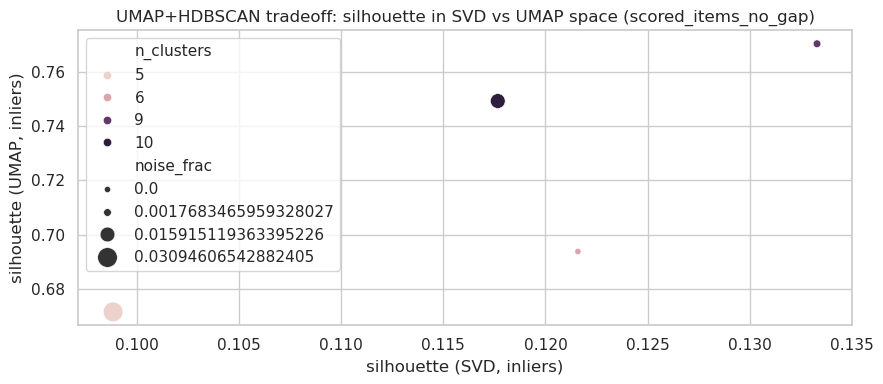

In [ ]:
# %%

fig, ax = plt.subplots(figsize=(9, 4))
tmp = umap_hdb[umap_hdb["feature_set"].eq("scored_items_no_gap")].copy()
sns.scatterplot(
    data=tmp,
    x="silhouette_svd_inliers",
    y="silhouette_umap_inliers",
    hue="n_clusters",
    size="noise_frac",
    sizes=(20, 200),
    ax=ax,
)
ax.set_title("UMAP+HDBSCAN tradeoff: silhouette in SVD vs UMAP space (scored_items_no_gap)")
ax.set_xlabel("silhouette (SVD, inliers)")
ax.set_ylabel("silhouette (UMAP, inliers)")
plt.tight_layout()
plt.show()

# %% [markdown]

 ### 3.1 Candidate selection (what we carry into interpretation)

 We prefer configurations with:
 - acceptable noise fraction (too much noise reduces usability),
 - a reasonable number of clusters (neither trivial 2 nor exploding into many tiny groups),
 - stability across UMAP seeds,
 - and shallow-tree explainability (clusters correspond to simple patterns in levers).

In [ ]:
# %%

cand = umap_hdb[umap_hdb["feature_set"].eq("scored_items_no_gap")].copy()
cand = cand[cand["noise_frac"] <= 0.2].copy()
cand = cand[cand["n_clusters"].between(3, 10)].copy()
cand = cand.sort_values(["tree_macro_f1", "stability_ari_seeds_0_1_2", "relative_validity"], ascending=[False, False, False]).head(15)
show_df(cand, "Finalist configurations (top)")

Finalist configurations (top)


,n_neighbors,min_dist,min_cluster_size,feature_set,n_clusters,noise_frac,relative_validity,silhouette_umap_inliers,silhouette_svd_inliers,stability_ari_seeds_0_1_2,tree_macro_f1,tree_n
8,10,0.1,50,scored_items_no_gap,6,0.000000,0.643575,0.693900,0.121587,0.998063,0.799329,1131
9,30,0.1,50,scored_items_no_gap,5,0.030946,0.403349,0.671718,0.098844,0.891394,0.687343,1096
10,10,0.0,50,scored_items_no_gap,9,0.001768,0.565825,0.770202,0.133287,0.962731,0.557049,1129
11,10,0.1,25,scored_items_no_gap,10,0.015915,0.533855,0.749155,0.117667,0.975963,0.495239,1113


# %% [markdown]

 ## 4) Cluster interpretation (profiles, drivers, overlays)

 We fix one configuration (as in notebook 04) and interpret clusters through:
 - cluster profiles (indices and key HR items),
 - lift tables (“drivers”),
 - mental-health outcome overlays (post-hoc).

 Important: clusters are defined on HR levers; burden outcomes are descriptive overlays.

In [ ]:
# %%

config_final = {
    "feature_set": "scored_items_no_gap",
    "min_frequency": 10,
    "svd_dim": 15,
    "umap_dim": 5,
    "n_neighbors": 10,
    "min_dist": 0.1,
    "min_cluster_size": 50,
    "min_samples": None,
    "seed": 0,
}

cols = sets[config_final["feature_set"]]
X = to_object_for_cat(df_feat[cols].copy())
pre = build_preprocessor(X, min_frequency=config_final["min_frequency"])
Xt = pre.fit_transform(X)
_, Z = embed_svd(Xt, n_components=config_final["svd_dim"])
res = eval_umap_hdbscan(
    Z,
    umap_dim=config_final["umap_dim"],
    n_neighbors=config_final["n_neighbors"],
    min_dist=config_final["min_dist"],
    min_cluster_size=config_final["min_cluster_size"],
    min_samples=config_final["min_samples"],
    seed=config_final["seed"],
)
labels = res["labels"]
Zu = res["Zu"]
show_df(pd.Series(labels).value_counts().sort_index().to_frame("n"), "Cluster sizes (including -1 noise)")

/home/gustas/software/miniconda3/envs/mental/lib/python3.11/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


Cluster sizes (including -1 noise)


,n
0,83
1,164
2,370
3,315
4,55
5,144


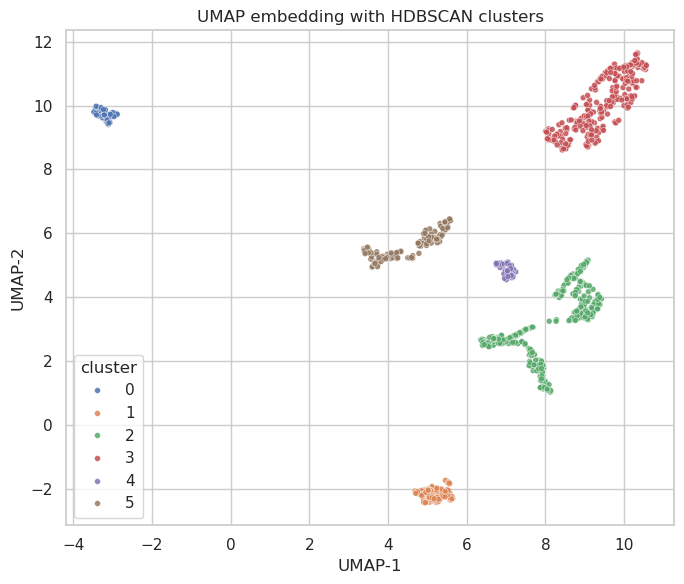

In [ ]:
# %%

if Zu.shape[1] >= 2:
    emb = pd.DataFrame({"x": Zu[:, 0], "y": Zu[:, 1], "cluster": labels})
    fig, ax = plt.subplots(figsize=(7, 6))
    hue_order = sorted([int(c) for c in emb["cluster"].dropna().unique().tolist()])
    sns.scatterplot(data=emb, x="x", y="y", hue="cluster", hue_order=hue_order, palette=sns.color_palette("deep", n_colors=len(hue_order)), s=18, alpha=0.85, ax=ax)
    ax.set_title("UMAP embedding with HDBSCAN clusters")
    ax.set_xlabel("UMAP-1")
    ax.set_ylabel("UMAP-2")
    plt.tight_layout()
    plt.show()

In [ ]:
# %%

def pct(series, value):
    s = series.astype(object).fillna("__MISSING__").astype(str).str.strip()
    return float((s == value).mean() * 100.0)


profile_rows = []
dfp = df_feat.copy()
dfp["cluster"] = labels
for cl, g in dfp[dfp["cluster"] != -1].groupby("cluster"):
    r = {"cluster": int(cl), "n": int(len(g))}
    for col in ["idx_support", "idx_safety", "qc_unknown_count", "qc_missing_count"]:
        if col in g.columns:
            r[f"{col}_mean"] = float(g[col].mean())
    if "benefits" in g.columns:
        r["benefits_yes_pct"] = pct(g["benefits"], "Yes")
    if "benefits_options_known" in g.columns:
        r["options_yes_pct"] = pct(g["benefits_options_known"], "Yes")
        r["options_no_pct"] = pct(g["benefits_options_known"], "No")
    if "anonymity_protected" in g.columns:
        r["anonymity_idk_pct"] = pct(g["anonymity_protected"], "I don't know")
    if "resources_available" in g.columns:
        r["resources_no_pct"] = pct(g["resources_available"], "No")
    if "supervisor_comfort" in g.columns:
        r["supervisor_no_pct"] = pct(g["supervisor_comfort"], "No")
    profile_rows.append(r)

profile = pd.DataFrame(profile_rows).sort_values("cluster").reset_index(drop=True)
show_df(profile, "Cluster profiles (selected KPIs)")

Cluster profiles (selected KPIs)


,cluster,n,idx_support_mean,idx_safety_mean,qc_unknown_count_mean,qc_missing_count_mean,benefits_yes_pct,options_yes_pct,options_no_pct,anonymity_idk_pct,resources_no_pct,supervisor_no_pct
0,0,83,0.243560,0.331325,0.975904,0.000000,30.120482,28.915663,34.939759,0.000000,71.084337,55.421687
1,1,164,0.195764,0.432927,1.823171,0.000000,0.000000,6.097561,37.195122,89.024390,87.195122,34.756098
2,2,370,0.500116,0.449730,1.910811,0.000000,73.243243,50.810811,22.972973,64.324324,39.459459,32.162162
3,3,315,0.365822,0.521270,3.365079,0.019048,31.746032,0.000000,43.809524,82.539683,46.349206,23.809524
4,4,55,0.728885,0.574545,2.509091,0.000000,43.636364,0.000000,36.363636,63.636364,49.090909,25.454545
5,5,144,0.900839,0.621528,1.194444,0.000000,72.222222,54.166667,11.111111,39.583333,1.388889,12.500000


In [ ]:
# %%

persona_map = {
    0: "Privacy-Seekers",
    1: "The Unaware",
    2: "The At-Risk",
    3: "The Disconnected",
    4: "The Self-Reliant",
    5: "Well-Supported",
}

# %% [markdown]

 ### 4.0.1 Full profile table for HR (counts + levers + burden overlays)

 The table below is designed to contain *all information needed* to build an HR-facing summary such as:

 - cluster id and persona label,
 - segment size,
 - “defining characteristics” in plain language with **data-verified percentages**,
 - burden overlays (e.g., current disorder rate),
 - support/safety index means.

 We compute both:
 - **within-cluster percentages** (what is true inside this persona), and
 - **lift** vs overall (what is unusually high/low compared to the whole modeling population).

In [ ]:
# %%

def _pct_of_value(series: pd.Series, value: str) -> float:
    s = series.astype(object).fillna("__MISSING__").astype(str).str.strip()
    return float((s == value).mean() * 100.0)


def _rate_current_disorder(frame: pd.DataFrame) -> float:
    if "current_disorder" not in frame.columns:
        return float("nan")
    s = _clean_str(frame["current_disorder"])
    return float(s.eq("Yes").mean() * 100.0)


def _rate_treatment(frame: pd.DataFrame) -> float:
    if "treatment_sought" not in frame.columns:
        return float("nan")
    s = _clean_str(frame["treatment_sought"])
    return float(s.isin(["Yes", "1", "1.0"]).mean() * 100.0)


df_in = df_feat.copy()
df_in["cluster"] = labels
df_in = df_in[df_in["cluster"] != -1].copy()
df_in["label"] = df_in["cluster"].map(persona_map).fillna("Persona (unlabeled)")

overall = df_in.copy()

cat_specs = [
    ("anonymity_protected", ["No", "I don't know", "Yes"]),
    ("supervisor_comfort", ["No", "Yes"]),
    ("resources_available", ["No", "Yes", "I don't know"]),
    ("benefits", ["No", "Yes"]),
    ("benefits_options_known", ["No", "Yes", "__not_applicable__"]),
    ("employer_serious", ["No", "Yes"]),
]
cat_specs = [(c, vals) for c, vals in cat_specs if c in df_in.columns]

full_rows = []
for cl, g in df_in.groupby(["cluster", "label"]):
    cluster_id, label = int(cl[0]), str(cl[1])
    row = {
        "cluster": cluster_id,
        "label": label,
        "count": int(len(g)),
        "idx_support_mean": float(g["idx_support"].mean()) if "idx_support" in g.columns else float("nan"),
        "idx_safety_mean": float(g["idx_safety"].mean()) if "idx_safety" in g.columns else float("nan"),
        "current_disorder_rate_pct": _rate_current_disorder(g),
        "treatment_sought_rate_pct": _rate_treatment(g),
    }
    for col, values in cat_specs:
        for v in values:
            row[f"{col}__{v}__pct"] = _pct_of_value(g[col], v)
            row[f"{col}__{v}__lift_pp"] = row[f"{col}__{v}__pct"] - _pct_of_value(overall[col], v)
    full_rows.append(row)

cluster_profile_full = pd.DataFrame(full_rows).sort_values("cluster").reset_index(drop=True)
show_df(cluster_profile_full, "Cluster profile (full table: levers + overlays)")

Cluster profile (full table: levers + overlays)


,cluster,label,count,idx_support_mean,idx_safety_mean,current_disorder_rate_pct,treatment_sought_rate_pct,anonymity_protected__No__pct,anonymity_protected__No__lift_pp,anonymity_protected__I don't know__pct,anonymity_protected__I don't know__lift_pp,anonymity_protected__Yes__pct,anonymity_protected__Yes__lift_pp,supervisor_comfort__No__pct,supervisor_comfort__No__lift_pp,supervisor_comfort__Yes__pct,supervisor_comfort__Yes__lift_pp,resources_available__No__pct,resources_available__No__lift_pp,resources_available__Yes__pct,resources_available__Yes__lift_pp,resources_available__I don't know__pct,resources_available__I don't know__lift_pp,benefits__No__pct,benefits__No__lift_pp,benefits__Yes__pct,benefits__Yes__lift_pp,benefits_options_known__No__pct,benefits_options_known__No__lift_pp,benefits_options_known__Yes__pct,benefits_options_known__Yes__lift_pp,benefits_options_known____not_applicable____pct,benefits_options_known____not_applicable____lift_pp,employer_serious__No__pct,employer_serious__No__lift_pp,employer_serious__Yes__pct,employer_serious__Yes__lift_pp
0,0,Privacy-Seekers,83,0.243560,0.331325,34.939759,56.626506,100.0,92.661362,0.000000,-65.075155,0.000000,-27.586207,55.421687,26.332385,24.096386,-13.392562,71.084337,24.842074,12.048193,-13.592833,16.867470,-11.249241,48.192771,29.625132,30.120482,-16.210199,34.939759,4.082111,28.915663,2.390464,13.253012,2.024011,49.397590,23.049226,19.277108,-11.315288
1,1,The Unaware,164,0.195764,0.432927,34.146341,48.170732,0.0,-7.338638,89.024390,23.949236,10.975610,-16.610597,34.756098,5.666796,30.487805,-7.001143,87.195122,40.952858,4.268293,-21.372733,8.536585,-19.580126,100.000000,81.432361,0.000000,-46.330681,37.195122,6.337474,6.097561,-20.427638,38.414634,27.185633,26.219512,-0.128852,20.731707,-9.860689
2,2,The At-Risk,370,0.500116,0.449730,50.810811,66.756757,0.0,-7.338638,64.324324,-0.750830,35.675676,8.089469,32.162162,3.072861,34.594595,-2.894353,39.459459,-6.782804,35.945946,10.304920,24.594595,-3.522116,0.000000,-18.567639,73.243243,26.912562,22.972973,-7.884675,50.810811,24.285612,2.972973,-8.256028,51.081081,24.732717,20.540541,-10.051856
3,3,The Disconnected,315,0.365822,0.521270,30.158730,47.301587,0.0,-7.338638,82.539683,17.464528,17.460317,-10.125889,23.809524,-5.279778,35.555556,-1.933392,46.349206,0.106943,0.317460,-25.323565,53.333333,25.216622,0.000000,-18.567639,31.746032,-14.584649,43.809524,12.951876,0.000000,-26.525199,7.619048,-3.609953,0.000000,-26.348364,32.698413,2.106017
4,4,The Self-Reliant,55,0.728885,0.574545,25.454545,56.363636,0.0,-7.338638,63.636364,-1.438791,36.363636,8.777429,25.454545,-3.634756,50.909091,13.420143,49.090909,2.848646,0.000000,-25.641026,50.909091,22.792380,0.000000,-18.567639,43.636364,-2.694317,36.363636,5.505988,0.000000,-26.525199,12.727273,1.498272,10.909091,-15.439273,49.090909,18.498513
5,5,Well-Supported,144,0.900839,0.621528,43.750000,66.666667,0.0,-7.338638,39.583333,-25.491821,60.416667,32.830460,12.500000,-16.589302,59.722222,22.233274,1.388889,-44.853375,96.527778,70.886752,2.083333,-26.033378,4.166667,-14.400973,72.222222,25.891541,11.111111,-19.746537,54.166667,27.641468,7.638889,-3.590112,13.194444,-13.153920,62.500000,31.907604


In [ ]:
# %%

# Cleaner version: only the metrics referenced in the HR "Corrected defining characteristics" bullets.
keep_map = {
    "cluster": "cluster",
    "label": "label",
    "count": "count",
    "idx_support_mean": "idx_support_mean",
    "idx_safety_mean": "idx_safety_mean",
    "current_disorder_rate_pct": "current_disorder_rate_pct",
    "anonymity_protected__No__pct": "anonymity_no_pct",
    "anonymity_protected__I don't know__pct": "anonymity_dk_pct",
    "supervisor_comfort__No__pct": "supervisor_no_pct",
    "resources_available__No__pct": "resources_no_pct",
    "benefits__No__pct": "benefits_no_pct",
    "benefits__Yes__pct": "benefits_yes_pct",
    "benefits_options_known__No__pct": "options_no_pct",
    "benefits_options_known__Yes__pct": "options_yes_pct",
    "employer_serious__No__pct": "employer_serious_no_pct",
}

cols_present = [c for c in keep_map.keys() if c in cluster_profile_full.columns]
cluster_profile_key = cluster_profile_full[cols_present].rename(columns={c: keep_map[c] for c in cols_present}).copy()

for c in cluster_profile_key.columns:
    if c.endswith("_pct") or c.endswith("_rate_pct"):
        cluster_profile_key[c] = cluster_profile_key[c].astype(float).round(1)
for c in ["idx_support_mean", "idx_safety_mean"]:
    if c in cluster_profile_key.columns:
        cluster_profile_key[c] = cluster_profile_key[c].astype(float).round(2)

show_df(cluster_profile_key, "Cluster profile (key metrics used in defining characteristics)")

Cluster profile (key metrics used in defining characteristics)


,cluster,label,count,idx_support_mean,idx_safety_mean,current_disorder_rate_pct,anonymity_no_pct,anonymity_dk_pct,supervisor_no_pct,resources_no_pct,benefits_no_pct,benefits_yes_pct,options_no_pct,options_yes_pct,employer_serious_no_pct
0,0,Privacy-Seekers,83,0.24,0.33,34.9,100.0,0.0,55.4,71.1,48.2,30.1,34.9,28.9,49.4
1,1,The Unaware,164,0.20,0.43,34.1,0.0,89.0,34.8,87.2,100.0,0.0,37.2,6.1,26.2
2,2,The At-Risk,370,0.50,0.45,50.8,0.0,64.3,32.2,39.5,0.0,73.2,23.0,50.8,51.1
3,3,The Disconnected,315,0.37,0.52,30.2,0.0,82.5,23.8,46.3,0.0,31.7,43.8,0.0,0.0
4,4,The Self-Reliant,55,0.73,0.57,25.5,0.0,63.6,25.5,49.1,0.0,43.6,36.4,0.0,10.9
5,5,Well-Supported,144,0.90,0.62,43.8,0.0,39.6,12.5,1.4,4.2,72.2,11.1,54.2,13.2


# %% [markdown]

 ### 4.0.2 “Corrected defining characteristics” (data-verified bullets)

 We generate a concise, HR-readable list of defining characteristics per cluster:

 - For categorical levers, we select the strongest differentiators based on absolute lift (percentage point difference vs overall).
 - We also add burden/indices highlights when a cluster has the highest/lowest value across clusters.

 This produces a table format that matches an HR summary slide: **Cluster / Label / Count / Defining characteristics**.

In [ ]:
# %%

def _format_pct(x: float) -> str:
    return f"{x:.1f}%"


def _pretty_feature(col: str) -> str:
    mapping = {
        "anonymity_protected": "Anonymity protected",
        "supervisor_comfort": "Supervisor comfort",
        "resources_available": "Resources available",
        "benefits": "Benefits",
        "benefits_options_known": "Options known",
        "employer_serious": "Employer seriousness",
    }
    return mapping.get(col, col)


def _pretty_answer(ans: str) -> str:
    if ans == "I don't know":
        return "\"Don't know\""
    if ans == "__not_applicable__":
        return "Not applicable"
    return f"\"{ans}\""


lift_cols = [c for c in cluster_profile_full.columns if c.endswith("__lift_pp")]
lift_long = []
for _, r in cluster_profile_full.iterrows():
    for c in lift_cols:
        pct_col = c.replace("__lift_pp", "__pct")
        base = c.split("__lift_pp")[0]
        feat, ans = base.split("__", 1)
        lift_long.append(
            {
                "cluster": int(r["cluster"]),
                "label": str(r["label"]),
                "feature": feat,
                "answer": ans,
                "pct_in_cluster": float(r[pct_col]),
                "lift_pp": float(r[c]),
                "abs_lift": abs(float(r[c])),
            }
        )

lift_long = pd.DataFrame(lift_long)

max_disorder = float(cluster_profile_full["current_disorder_rate_pct"].max())
min_disorder = float(cluster_profile_full["current_disorder_rate_pct"].min())
max_support = float(cluster_profile_full["idx_support_mean"].max()) if "idx_support_mean" in cluster_profile_full.columns else float("nan")
max_safety = float(cluster_profile_full["idx_safety_mean"].max()) if "idx_safety_mean" in cluster_profile_full.columns else float("nan")

rows = []
for _, r in cluster_profile_full.iterrows():
    cl = int(r["cluster"])
    label = str(r["label"])
    n = int(r["count"])

    dd = lift_long[lift_long["cluster"] == cl].copy()
    # Prefer levers that are most actionable/central for HR; then rank by absolute lift.
    prefer_feats = ["anonymity_protected", "supervisor_comfort", "resources_available", "benefits", "benefits_options_known", "employer_serious"]
    dd["feat_rank"] = dd["feature"].map(lambda f: prefer_feats.index(f) if f in prefer_feats else 999)
    dd = dd.sort_values(["feat_rank", "abs_lift"], ascending=[True, False])
    dd = dd.groupby("feature", as_index=False).head(1).sort_values("abs_lift", ascending=False).head(4)

    bullets = []
    for _, d in dd.iterrows():
        bullets.append(f"• {_format_pct(d['pct_in_cluster'])} {_pretty_answer(d['answer'])} to {_pretty_feature(d['feature'])}")

    disorder = float(r["current_disorder_rate_pct"])
    if np.isfinite(disorder):
        if disorder == max_disorder:
            bullets.insert(0, f"• {_format_pct(disorder)} current disorder rate (highest)")
        elif disorder == min_disorder:
            bullets.insert(0, f"• {_format_pct(disorder)} current disorder rate (lowest)")

    if "idx_support_mean" in r and np.isfinite(float(r["idx_support_mean"])) and float(r["idx_support_mean"]) == max_support:
        bullets.append(f"• Highest support index (mean={float(r['idx_support_mean']):.2f})")
    if "idx_safety_mean" in r and np.isfinite(float(r["idx_safety_mean"])) and float(r["idx_safety_mean"]) == max_safety:
        bullets.append(f"• Highest safety index (mean={float(r['idx_safety_mean']):.2f})")

    rows.append(
        {
            "cluster": cl,
            "label": label,
            "count": n,
            "corrected_defining_characteristics_data_verified": "\n".join(bullets),
        }
    )

cluster_hr_summary = pd.DataFrame(rows).sort_values("cluster").reset_index(drop=True)
show_df(cluster_hr_summary, "HR summary table: Cluster / Label / Count / Corrected defining characteristics")

HR summary table: Cluster / Label / Count / Corrected defining characteristics


,cluster,label,count,corrected_defining_characteristics_data_verified
0,0,Privacy-Seekers,83,"• 100.0% ""No"" to Anonymity protected\n• 48.2% ..."
1,1,The Unaware,164,"• 100.0% ""No"" to Benefits\n• 87.2% ""No"" to Res..."
2,2,The At-Risk,370,• 50.8% current disorder rate (highest)\n• 73....
3,3,The Disconnected,315,"• 0.0% ""Yes"" to Options known\n• 0.0% ""No"" to ..."
4,4,The Self-Reliant,55,• 25.5% current disorder rate (lowest)\n• 0.0%...
5,5,Well-Supported,144,"• 96.5% ""Yes"" to Resources available\n• 60.4% ..."


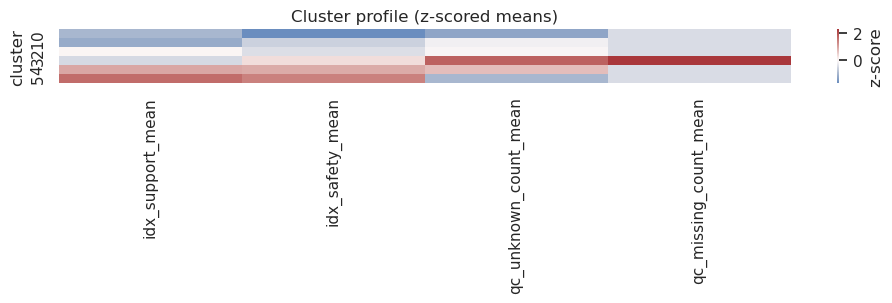

In [ ]:
# %%

heat_cols = [c for c in profile.columns if c.endswith("_mean")]
if heat_cols:
    fig, ax = plt.subplots(figsize=(10, 3.2))
    Zp = profile.set_index("cluster")[heat_cols]
    Zz = (Zp - Zp.mean()) / (Zp.std(ddof=0) + 1e-9)
    sns.heatmap(Zz, cmap="vlag", center=0, ax=ax, cbar_kws={"label": "z-score"})
    ax.set_title("Cluster profile (z-scored means)")
    plt.tight_layout()
    plt.show()

In [ ]:
# %%

driver_feats = [
    "benefits",
    "benefits_options_known",
    "resources_available",
    "anonymity_protected",
    "supervisor_comfort",
    "coworker_comfort",
    "mental_health_consequences",
    "career_harm",
    "leave_ease",
    "employer_serious",
    "remote_work",
    "company_size",
]
drivers = top_lift_drivers(df_feat, labels, driver_feats, top_n=12)
show_df(drivers.head(40), "Top lift drivers (head)")

Top lift drivers (head)


,cluster,feature,answer,pct_in_cluster,pct_overall,lift_pp
0,0,anonymity_protected,No,100.000000,7.338638,92.661362
1,0,benefits,No,48.192771,18.567639,29.625132
2,0,supervisor_comfort,No,55.421687,29.089302,26.332385
3,0,resources_available,No,71.084337,46.242263,24.842074
4,0,mental_health_consequences,Yes,42.168675,18.832891,23.335783
5,0,employer_serious,No,49.397590,26.348364,23.049226
6,0,company_size,1-5,22.891566,5.216622,17.674944
7,0,benefits,Yes,30.120482,46.330681,-16.210199
8,0,mental_health_consequences,No,22.891566,38.549956,-15.658390
9,0,coworker_comfort,No,49.397590,34.129089,15.268501


# %% [markdown]

 ### 4.1 Persona labels and “traffic light” summary

 Numeric cluster IDs are convenient for modeling but not for HR communication.
 We map clusters to persona-style labels based on the dominant differentiators and KPI patterns.
 The “traffic light” table is a compact HR dashboard view across key levers (support, safety, anonymity clarity, benefits navigation).

In [ ]:
# %%

df_seg = df_feat.copy()
df_seg["cluster"] = labels
df_seg = df_seg[df_seg["cluster"] != -1].copy()
df_seg["persona"] = df_seg["cluster"].map(persona_map).fillna("Persona (unlabeled)")


def traffic_light(value, q_low, q_high, higher_is_better=True):
    if value is None or (isinstance(value, float) and np.isnan(value)):
        return "NA"
    if higher_is_better:
        if value <= q_low:
            return "RED"
        if value >= q_high:
            return "GREEN"
        return "YELLOW"
    if value >= q_high:
        return "RED"
    if value <= q_low:
        return "GREEN"
    return "YELLOW"


traffic = profile[["cluster", "n"]].copy()
traffic["persona"] = traffic["cluster"].map(persona_map).fillna("Persona (unlabeled)")

q_support = df_feat["idx_support"].quantile([0.25, 0.75]).to_dict() if "idx_support" in df_feat.columns else {}
q_safety = df_feat["idx_safety"].quantile([0.25, 0.75]).to_dict() if "idx_safety" in df_feat.columns else {}

if "idx_support_mean" in profile.columns:
    traffic["support_level"] = profile["idx_support_mean"].map(lambda v: traffic_light(v, q_support.get(0.25, np.nan), q_support.get(0.75, np.nan), True))
if "idx_safety_mean" in profile.columns:
    traffic["safety_level"] = profile["idx_safety_mean"].map(lambda v: traffic_light(v, q_safety.get(0.25, np.nan), q_safety.get(0.75, np.nan), True))
if "anonymity_idk_pct" in profile.columns:
    q_idk = profile["anonymity_idk_pct"].quantile([0.25, 0.75]).to_dict()
    traffic["anonymity_clarity"] = profile["anonymity_idk_pct"].map(lambda v: traffic_light(v, q_idk.get(0.25, np.nan), q_idk.get(0.75, np.nan), higher_is_better=False))
if "options_yes_pct" in profile.columns:
    q_opt = profile["options_yes_pct"].quantile([0.25, 0.75]).to_dict()
    traffic["benefits_navigation"] = profile["options_yes_pct"].map(lambda v: traffic_light(v, q_opt.get(0.25, np.nan), q_opt.get(0.75, np.nan), True))

show_df(traffic, "Traffic light table (per cluster/persona)")

Traffic light table (per cluster/persona)


,cluster,n,persona,support_level,safety_level,anonymity_clarity,benefits_navigation
0,0,83,Privacy-Seekers,YELLOW,YELLOW,GREEN,YELLOW
1,1,164,The Unaware,YELLOW,YELLOW,RED,YELLOW
2,2,370,The At-Risk,YELLOW,YELLOW,YELLOW,GREEN
3,3,315,The Disconnected,YELLOW,YELLOW,RED,RED
4,4,55,The Self-Reliant,GREEN,YELLOW,YELLOW,RED
5,5,144,Well-Supported,GREEN,YELLOW,GREEN,GREEN


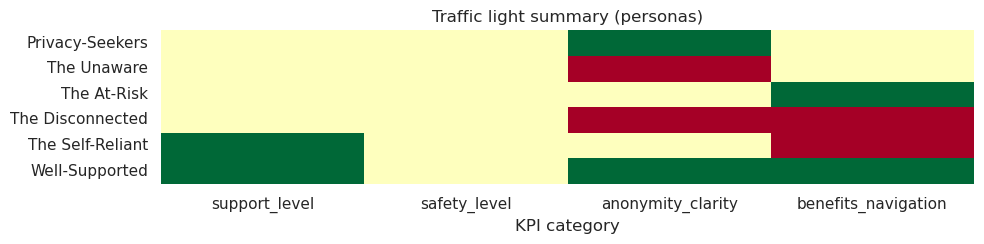

In [ ]:
# %%

fig, ax = plt.subplots(figsize=(10, 2.6))
cols = [c for c in ["support_level", "safety_level", "anonymity_clarity", "benefits_navigation"] if c in traffic.columns]
map_color = {"RED": 0, "YELLOW": 1, "GREEN": 2, "NA": np.nan}
M = traffic.set_index("persona")[cols].replace(map_color).astype(float)
sns.heatmap(M, cmap="RdYlGn", vmin=0, vmax=2, cbar=False, ax=ax)
ax.set_title("Traffic light summary (personas)")
ax.set_xlabel("KPI category")
ax.set_ylabel("")
plt.tight_layout()
plt.show()

# %% [markdown]

 ### 4.2 Burden overlays by persona (post-hoc)

 These overlays help size interventions:
 - current disorder rate/cases (self-reported),
 - treatment sought rate/cases.

 They are descriptive, not causal.

In [ ]:
# %%

def _as_clean_str(x):
    if x is None or (isinstance(x, float) and np.isnan(x)) or pd.isna(x):
        return None
    s = str(x).strip()
    return s if s else None


def _is_yes_like(x):
    if isinstance(x, (int, np.integer)) and x == 1:
        return True
    if isinstance(x, (float, np.floating)) and np.isfinite(x) and float(x) == 1.0:
        return True
    s = _as_clean_str(x)
    if s is None:
        return False
    return s in {"Yes", "1", "1.0", "True", "true"}


def _is_current_disorder_yes(x):
    s = _as_clean_str(x)
    return s == "Yes"


rows = []
for persona, g in df_seg.groupby("persona"):
    n = int(len(g))
    disorders = int(g["current_disorder"].map(_is_current_disorder_yes).sum()) if "current_disorder" in g.columns else np.nan
    treated = int(g["treatment_sought"].map(_is_yes_like).sum()) if "treatment_sought" in g.columns else np.nan
    rows.append(
        {
            "persona": persona,
            "n": n,
            "current_disorder_cases": disorders,
            "current_disorder_rate": float(disorders / n) if n > 0 else np.nan,
            "treatment_sought_cases": treated,
            "treatment_sought_rate": float(treated / n) if n > 0 else np.nan,
        }
    )

persona_mh = pd.DataFrame(rows).sort_values("n", ascending=False).reset_index(drop=True)
show_df(persona_mh, "Burden overlays by persona")

Burden overlays by persona


,persona,n,current_disorder_cases,current_disorder_rate,treatment_sought_cases,treatment_sought_rate
0,The At-Risk,370,188,0.508108,247,0.667568
1,The Disconnected,315,95,0.301587,149,0.473016
2,The Unaware,164,56,0.341463,79,0.481707
3,Well-Supported,144,63,0.437500,96,0.666667
4,Privacy-Seekers,83,29,0.349398,47,0.566265
5,The Self-Reliant,55,14,0.254545,31,0.563636


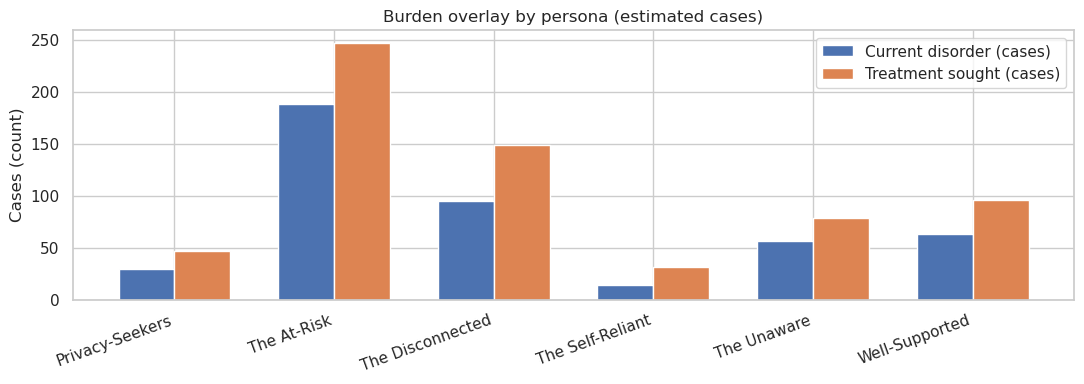

In [ ]:
# %%

fig, ax = plt.subplots(figsize=(11, 4))
tmp = persona_mh.sort_values("persona")
idx = np.arange(len(tmp))
w = 0.35
ax.bar(idx - w / 2, tmp["current_disorder_cases"], width=w, label="Current disorder (cases)", color=PALETTE[0])
ax.bar(idx + w / 2, tmp["treatment_sought_cases"], width=w, label="Treatment sought (cases)", color=PALETTE[1])
ax.set_xticks(idx)
ax.set_xticklabels(tmp["persona"], rotation=20, ha="right")
ax.set_title("Burden overlay by persona (estimated cases)")
ax.set_ylabel("Cases (count)")
ax.legend()
plt.tight_layout()
plt.show()

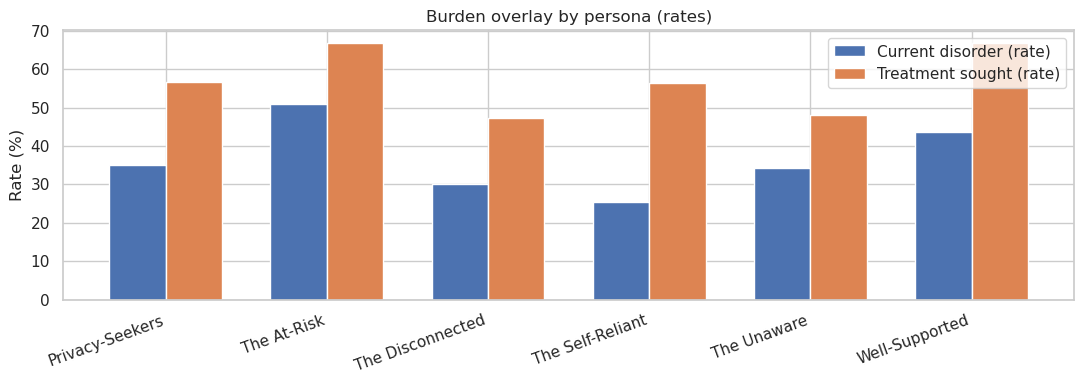

In [ ]:
# %%

fig, ax = plt.subplots(figsize=(11, 4))
ax.bar(idx - w / 2, 100 * tmp["current_disorder_rate"], width=w, label="Current disorder (rate)", color=PALETTE[0])
ax.bar(idx + w / 2, 100 * tmp["treatment_sought_rate"], width=w, label="Treatment sought (rate)", color=PALETTE[1])
ax.set_xticks(idx)
ax.set_xticklabels(tmp["persona"], rotation=20, ha="right")
ax.set_title("Burden overlay by persona (rates)")
ax.set_ylabel("Rate (%)")
ax.legend()
plt.tight_layout()
plt.show()

# %% [markdown]

 ### 4.3 Explainability sanity check (shallow tree)

 We fit a shallow decision tree to predict cluster labels from interpretable levers.
 If the tree has reasonable macro-F1, it supports the interpretation that clusters correspond to simple patterns in levers
 (as opposed to being purely embedding artifacts).

In [ ]:
# %%

from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import confusion_matrix, f1_score

explain_feats = [
    "benefits",
    "benefits_options_known",
    "resources_available",
    "anonymity_protected",
    "leave_ease",
    "employer_serious",
    "supervisor_comfort",
    "coworker_comfort",
    "mental_health_consequences",
    "career_harm",
    "team_views_negative",
    "remote_work",
    "company_size",
    "idx_support",
    "idx_safety",
    "qc_unknown_count",
]
explain_feats = [c for c in explain_feats if c in df_feat.columns]

mask = labels != -1
Xexp = df_feat.loc[mask, explain_feats].copy()
yexp = pd.Series(labels[mask], name="cluster")

for c in Xexp.columns:
    if not pd.api.types.is_numeric_dtype(Xexp[c].dtype):
        Xexp[c] = Xexp[c].astype("string").fillna("__MISSING__")

Xenc = pd.get_dummies(Xexp, drop_first=False)
clf = DecisionTreeClassifier(max_depth=3, random_state=0, min_samples_leaf=15)
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=0)

pred = np.zeros(len(yexp), dtype=int)
for tr, te in cv.split(Xenc, yexp):
    clf.fit(Xenc.iloc[tr], yexp.iloc[tr])
    pred[te] = clf.predict(Xenc.iloc[te])

cm = confusion_matrix(yexp, pred, labels=sorted(yexp.unique()))
cm_df = pd.DataFrame(cm, index=[f"true_{c}" for c in sorted(yexp.unique())], columns=[f"pred_{c}" for c in sorted(yexp.unique())])
f1_macro = float(f1_score(yexp, pred, average="macro"))
show_df(pd.DataFrame([{"cv_macro_f1": f1_macro, "n_inliers": int(mask.sum())}]), "Shallow-tree explainability (summary)")

Shallow-tree explainability (summary)


,cv_macro_f1,n_inliers
0,0.631519,1131


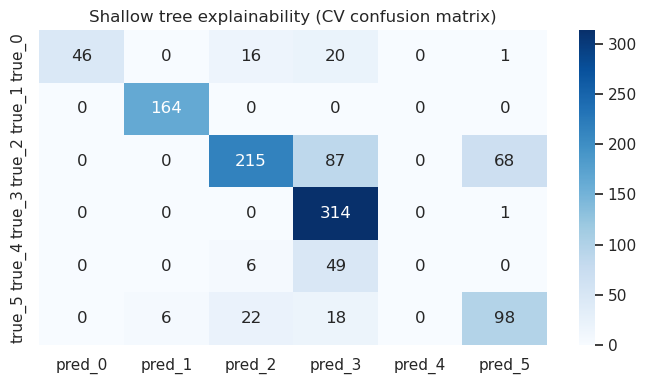

In [ ]:
# %%

fig, ax = plt.subplots(figsize=(7, 4))
sns.heatmap(cm_df, annot=True, fmt="d", cmap="Blues", ax=ax)
ax.set_title("Shallow tree explainability (CV confusion matrix)")
plt.tight_layout()
plt.show()

# %% [markdown]

 ## 5) Predictive checks (association, not causation)

 We quantify out-of-sample signal of HR-lever feature sets for burden proxies via cross-validated logistic regression.
 A dummy-prior baseline is included to show “how much better than predicting the prior” we are.

 Interpretation:
 - AUC is a ranking metric: 0.5 is random.
 - Average precision’s naive baseline is approximately the positive rate.

 Even a “decent” AUC does **not** establish causality; this is prioritization evidence only.

In [ ]:
# %%

from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.dummy import DummyClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score, average_precision_score


def build_preprocessor_for_predict(X):
    num = X.select_dtypes(include=["number"]).columns.tolist()
    cat = [c for c in X.columns if c not in num]
    return ColumnTransformer(
        transformers=[
            ("num", Pipeline([("imputer", SimpleImputer(strategy="median")), ("scaler", StandardScaler())]), num),
            ("cat", Pipeline([("imputer", SimpleImputer(strategy="constant", fill_value=MISSING_TOKEN)), ("onehot", OneHotEncoder(handle_unknown="ignore", min_frequency=10))]), cat),
        ],
        remainder="drop",
        sparse_threshold=0.3,
    )


def cv_scores(X, y, pipe, n_splits=5, seed=0):
    cv = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=seed)
    aucs, aps = [], []
    for tr, te in cv.split(X, y):
        pipe.fit(X.iloc[tr], y.iloc[tr])
        p = pipe.predict_proba(X.iloc[te])[:, 1]
        aucs.append(roc_auc_score(y.iloc[te], p))
        aps.append(average_precision_score(y.iloc[te], p))
    aucs = np.asarray(aucs, dtype=float)
    aps = np.asarray(aps, dtype=float)
    return {"roc_auc_mean": float(aucs.mean()), "roc_auc_std": float(aucs.std(ddof=1)), "avg_precision_mean": float(aps.mean()), "avg_precision_std": float(aps.std(ddof=1))}


def y_treatment(frame):
    s = _clean_str(frame["treatment_sought"])
    mask = ~s.eq("")
    y = s.isin(["1", "1.0", "Yes"]).astype(int)
    return y.where(mask)


def y_current_disorder(frame):
    s = _clean_str(frame["current_disorder"])
    mask = ~s.eq("")
    y = s.eq("Yes").astype(int)
    return y.where(mask)


def y_interfere_untreated_often_applicable(frame):
    s = _clean_str(frame["work_interference_untreated"])
    mask = ~s.eq("Not applicable to me")
    y = s.eq("Often").astype(int)
    return y.where(mask)


outcomes = {
    "treatment_yes": y_treatment,
    "current_disorder_yes": y_current_disorder,
    "interfere_untreated_often_applicable": y_interfere_untreated_often_applicable,
}

pred_sets = {
    "indices_only": sets["indices_only"],
    "workplace_no_roles": sets["workplace_no_roles"],
    "scored_items_no_gap": sets["scored_items_no_gap"],
}

rows = []
for out_name, fn in outcomes.items():
    y = fn(df_feat)
    mask = y.notna()
    y = y.loc[mask].astype(int)
    for set_name, cols in pred_sets.items():
        X = to_object_for_cat(df_feat.loc[mask, cols].copy())
        pre = build_preprocessor_for_predict(X)
        pos_rate = float(y.mean())

        logreg = Pipeline([("pre", pre), ("clf", LogisticRegression(max_iter=5000, solver="lbfgs", C=1.0))])
        dummy = Pipeline([("pre", pre), ("clf", DummyClassifier(strategy="prior"))])

        rows.append({"outcome": out_name, "feature_set": set_name, "model": "logreg", "n": int(len(X)), "pos_rate": pos_rate, **cv_scores(X, y, logreg)})
        rows.append({"outcome": out_name, "feature_set": set_name, "model": "dummy_prior", "n": int(len(X)), "pos_rate": pos_rate, **cv_scores(X, y, dummy)})

metrics = pd.DataFrame(rows).sort_values(["outcome", "feature_set", "model"]).reset_index(drop=True)
show_df(metrics, "Predictive CV metrics (logreg vs dummy)")

Predictive CV metrics (logreg vs dummy)


,outcome,feature_set,model,n,pos_rate,roc_auc_mean,roc_auc_std,avg_precision_mean,avg_precision_std
0,current_disorder_yes,indices_only,dummy_prior,1131,0.393457,0.500000,0.000000,0.393458,0.000776
1,current_disorder_yes,indices_only,logreg,1131,0.393457,0.596659,0.039128,0.487588,0.039303
2,current_disorder_yes,scored_items_no_gap,dummy_prior,1131,0.393457,0.500000,0.000000,0.393458,0.000776
3,current_disorder_yes,scored_items_no_gap,logreg,1131,0.393457,0.649535,0.021508,0.539428,0.026118
4,current_disorder_yes,workplace_no_roles,dummy_prior,1131,0.393457,0.500000,0.000000,0.393458,0.000776
5,current_disorder_yes,workplace_no_roles,logreg,1131,0.393457,0.681370,0.025774,0.595052,0.031306
6,interfere_untreated_often_applicable,indices_only,dummy_prior,753,0.551129,0.500000,0.000000,0.551135,0.002007
7,interfere_untreated_often_applicable,indices_only,logreg,753,0.551129,0.567251,0.064211,0.628823,0.058048
8,interfere_untreated_often_applicable,scored_items_no_gap,dummy_prior,753,0.551129,0.500000,0.000000,0.551135,0.002007
9,interfere_untreated_often_applicable,scored_items_no_gap,logreg,753,0.551129,0.594861,0.041032,0.645785,0.033630


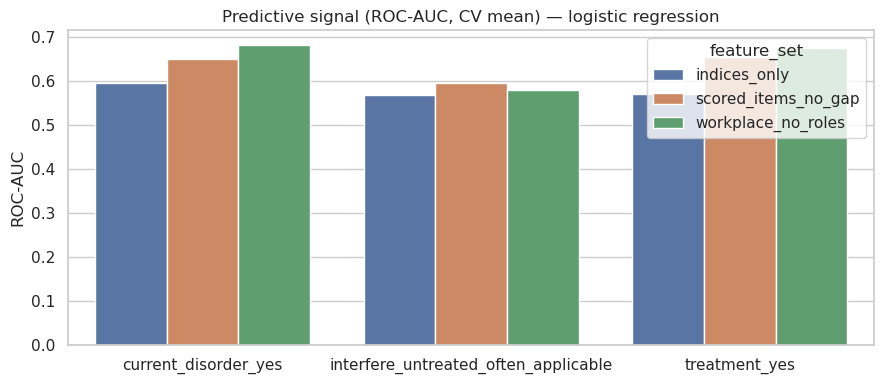

In [ ]:
# %%

fig, ax = plt.subplots(figsize=(9, 4))
tmp = metrics[metrics["model"].eq("logreg")].copy()
sns.barplot(data=tmp, x="outcome", y="roc_auc_mean", hue="feature_set", ax=ax)
ax.set_title("Predictive signal (ROC-AUC, CV mean) — logistic regression")
ax.set_xlabel("")
ax.set_ylabel("ROC-AUC")
plt.tight_layout()
plt.show()

In [ ]:
# %%

wide_auc = metrics.pivot_table(index=["outcome", "feature_set"], columns="model", values="roc_auc_mean", aggfunc="first").reset_index()
wide_auc["auc_uplift_vs_dummy"] = wide_auc["logreg"] - wide_auc["dummy_prior"]
show_df(wide_auc.sort_values(["outcome", "auc_uplift_vs_dummy"], ascending=[True, False]), "AUC uplift vs dummy baseline")

AUC uplift vs dummy baseline


model,outcome,feature_set,dummy_prior,logreg,auc_uplift_vs_dummy
2,current_disorder_yes,workplace_no_roles,0.5,0.681370,0.181370
1,current_disorder_yes,scored_items_no_gap,0.5,0.649535,0.149535
0,current_disorder_yes,indices_only,0.5,0.596659,0.096659
4,interfere_untreated_often_applicable,scored_items_no_gap,0.5,0.594861,0.094861
5,interfere_untreated_often_applicable,workplace_no_roles,0.5,0.580356,0.080356
3,interfere_untreated_often_applicable,indices_only,0.5,0.567251,0.067251
8,treatment_yes,workplace_no_roles,0.5,0.675462,0.175462
7,treatment_yes,scored_items_no_gap,0.5,0.654097,0.154097
6,treatment_yes,indices_only,0.5,0.570992,0.070992


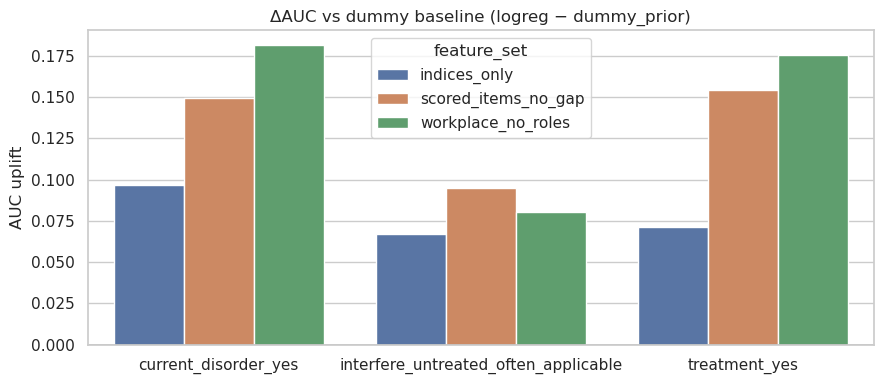

In [ ]:
# %%

fig, ax = plt.subplots(figsize=(9, 4))
sns.barplot(data=wide_auc, x="outcome", y="auc_uplift_vs_dummy", hue="feature_set", ax=ax)
ax.axhline(0, color="black", linewidth=1)
ax.set_title("ΔAUC vs dummy baseline (logreg − dummy_prior)")
ax.set_xlabel("")
ax.set_ylabel("AUC uplift")
plt.tight_layout()
plt.show()

# %% [markdown]

 ### 5.1 “Which levers matter?” (coefficient summaries; interpretation-only)

 We fit logistic regression on the full dataset (for each outcome) and summarize coefficients.
 Caveats:
 - coefficients are conditional associations and can be unstable under collinearity,
 - the primary claim remains cross-validated performance above.

 We:
 - list top encoded coefficients,
 - then aggregate absolute coefficient mass back to the base feature level.

In [ ]:
# %%

def fit_full_and_extract(pipe, X, y):
    pipe.fit(X, y)
    pre = pipe.named_steps["pre"]
    clf = pipe.named_steps["clf"]
    names = list(pre.get_feature_names_out())
    coefs = clf.coef_.ravel()
    out = pd.DataFrame({"encoded_feature": names, "coef": coefs})
    out["abs_coef"] = out["coef"].abs()
    return out.sort_values("abs_coef", ascending=False)


def infer_base_feature(encoded_feature, base_cols):
    if encoded_feature.startswith("num__"):
        return encoded_feature.replace("num__", "")
    if encoded_feature.startswith("cat__"):
        rest = encoded_feature.replace("cat__", "")
        candidates = sorted(base_cols, key=len, reverse=True)
        for c in candidates:
            if rest == c or rest.startswith(c + "_"):
                return c
        return rest.split("_")[0]
    return encoded_feature


coef_rows = []
for out_name, fn in outcomes.items():
    y = fn(df_feat)
    mask = y.notna()
    y = y.loc[mask].astype(int)
    cols = pred_sets["workplace_no_roles"]
    X = to_object_for_cat(df_feat.loc[mask, cols].copy())
    pre = build_preprocessor_for_predict(X)
    clf = LogisticRegression(max_iter=5000, solver="lbfgs", C=1.0)
    pipe = Pipeline([("pre", pre), ("clf", clf)])
    coef_df = fit_full_and_extract(pipe, X, y)
    coef_df["outcome"] = out_name
    coef_df["base_feature"] = coef_df["encoded_feature"].map(lambda s: infer_base_feature(s, cols))
    coef_rows.append(coef_df.head(30)[["outcome", "encoded_feature", "coef", "base_feature"]])

top_encoded_all = pd.concat(coef_rows, ignore_index=True)
show_df(top_encoded_all, "Top encoded coefficients (|coef|), interpretation-only")

Top encoded coefficients (|coef|), interpretation-only


,outcome,encoded_feature,coef,base_feature
0,treatment_yes,cat__benefits_options_known_Yes,0.993439,benefits_options_known
1,treatment_yes,"cat__career_harm_Yes, it has",0.835149,career_harm
2,treatment_yes,cat__leave_ease_Very difficult,0.725786,leave_ease
3,treatment_yes,cat__career_harm_Maybe,-0.623777,career_harm
4,treatment_yes,"cat__team_views_negative_Yes, they do",0.623445,team_views_negative
...,...,...,...,...
85,interfere_untreated_often_applicable,"cat__career_harm_Yes, I think it would",0.176115,career_harm
86,interfere_untreated_often_applicable,cat__resources_available_No,0.175132,resources_available
87,interfere_untreated_often_applicable,cat__leave_ease_Very easy,0.173955,leave_ease
88,interfere_untreated_often_applicable,cat__remote_work_Sometimes,0.172022,remote_work


In [ ]:
# %%

base_importance = top_encoded_all.copy()
base_importance["abs_coef"] = base_importance["coef"].abs()
base_importance = base_importance.groupby(["outcome", "base_feature"])["abs_coef"].sum().sort_values(ascending=False).reset_index()
show_df(base_importance.groupby("outcome").head(15), "Base feature importance (sum of |coef| over top encoded terms)")

Base feature importance (sum of |coef| over top encoded terms)


,outcome,base_feature,abs_coef
0,current_disorder_yes,team_views_negative,3.049034
1,treatment_yes,career_harm,2.681209
2,treatment_yes,leave_ease,2.450126
3,treatment_yes,team_views_negative,2.179959
4,treatment_yes,benefits_options_known,2.107147
5,current_disorder_yes,leave_ease,1.651185
6,current_disorder_yes,career_harm,1.611857
7,current_disorder_yes,benefits_options_known,1.525323
8,interfere_untreated_often_applicable,career_harm,1.171524
9,interfere_untreated_often_applicable,benefits_options_known,1.146641


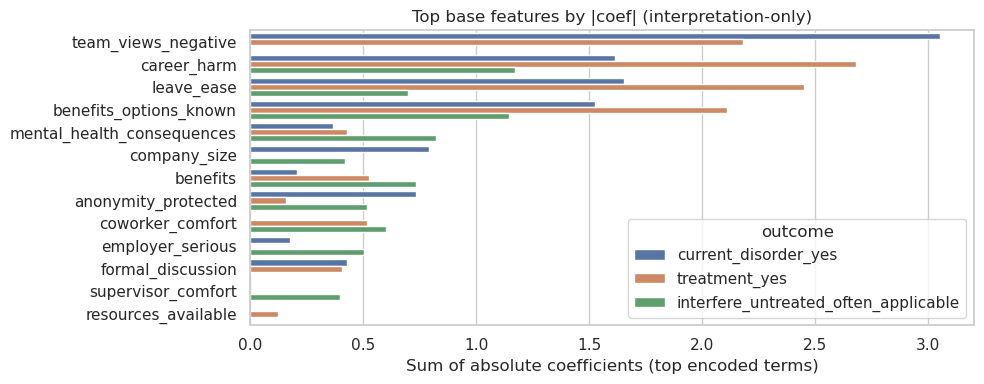

In [ ]:
# %%

fig, ax = plt.subplots(figsize=(10, 4))
tmp = base_importance.groupby("outcome").head(10)
sns.barplot(data=tmp, y="base_feature", x="abs_coef", hue="outcome", ax=ax)
ax.set_title("Top base features by |coef| (interpretation-only)")
ax.set_xlabel("Sum of absolute coefficients (top encoded terms)")
ax.set_ylabel("")
plt.tight_layout()
plt.show()

# %% [markdown]

 ## Conclusions (what is robust vs what not to overclaim)

 Robust:
 - Routing and structural missingness are real and must be handled; otherwise clusters can reflect eligibility rather than HR levers.
 - Workplace levers admit interpretable segments with consistent “lift” differentiators.

 Expected limitations:
 - Predictive signal for burden proxies is at best moderate. Burden depends on many non-workplace factors and the outcomes are noisy.

 Avoid overclaiming:
 - This is cross-sectional observational survey data. Cluster differences and predictive associations are not causal effects.